In [1]:
import sys
from ioMicro import *

In [9]:
scoresRef=None

In [2]:
save_folder =r'/mnt/merfish11/20230919_R128_N5S1MER3_analysis'

In [4]:
compute_flat_fields(save_folder)

  0%|          | 0/762 [00:00<?, ?it/s]/home/plt3/anaconda3/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:802: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
100%|██████████| 762/762 [01:58<00:00,  6.42it/s]
/home/plt3/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
100%|██████████| 762/762 [01:42<00:00,  7.43it/s]


In [11]:
save_folder =r'/mnt/merfish11/20230919_R128_N5S1MER3_analysis/RMERFISH/'
fov,set_ = 'Conv_zscan__415.zarr', '' ##415,361
dec = decoder_simple(save_folder,fov,set_)
dec.ncols = 3
dec.load_decoded()
#apply_flat_field(dec)
#apply_fine_drift(dec,plt_val=True)
scoresRefT = get_score_per_color(dec)

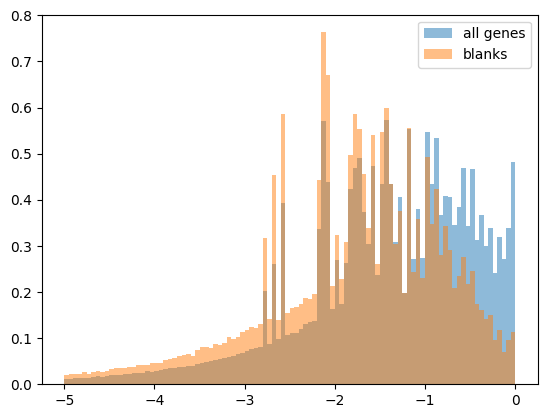

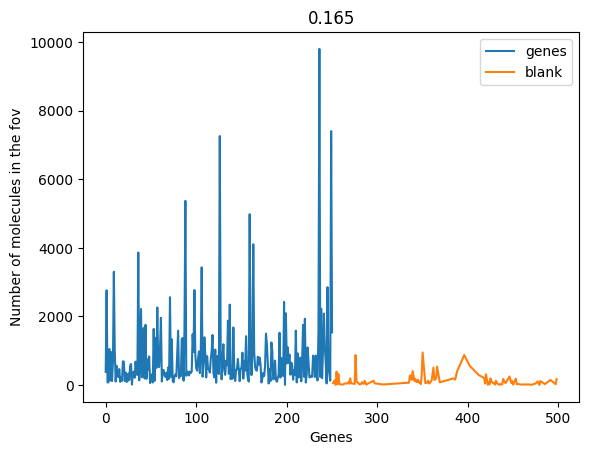

In [12]:
get_score_withRef(dec,scoresRefT,plt_val=True,gene=None,iSs = None,th_min=-5)
dec.th=-0.75
plot_statistics(dec)

In [37]:
### load the immeds
tag='med_col_raw'
Icol = dec.XH_pruned[:,:,-2].astype(int)
uIcols = np.unique(Icol)
dec.ncols = len(uIcols)
save_folder=dec.save_folder#r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
immeds = []
for icol in range(dec.ncols):
    fl_med = save_folder+os.sep+tag+str(icol)+'.npz'
    if not os.path.exists(fl_med):
        fl_med = fl_med.replace('_raw','')
    dic = np.load(fl_med)
    immed,resc=dic['im'],dic['resc']
    immeds.append(immed)
dec.immeds = np.array(immeds)
dec.resc = resc

### renormalize the brightness according to flatfield
XH = dec.XH_pruned
Icol = XH[:,:,-2].astype(int)
H = dec.XH_pruned[:,:,-3].copy()
for icol in range(dec.ncols):
    keep = Icol==icol
    immed = dec.immeds[icol].copy()
    immed = immed/np.nanmedian(immed)
    x_,y_ = ((XH[keep][:,1:3]/dec.resc).astype(int)%immed.shape).T
    norm_ = immed[x_,y_] 
    H[keep]=H[keep]/norm_
#dec.XH_pruned[:,:,-3] = H

In [40]:
np.sum(np.isnan(H))

0

In [13]:
if True:
    if scoresRef is None: scoresRef=scoresRefT
    else: combine_scoresRef(scoresRef,scoresRefT)
    np.save(save_folder+os.sep+'scoresRef.npy',scoresRef)

In [ ]:
save_fl = dec.save_folder+os.sep+os.sep+tag_save+dec.fov.split('.')[0]+'--'+dec.set_+'.npz'

In [ ]:
fovs_fl = save_folder + os.sep + "fovs__" + "" + ".npy"
fovs = np.load(fovs_fl)
from multiprocessing import Pool

def func(fov):
   save_final_decoding(save_folder, fov, scoresRef=save_folder+os.sep+'scoresRef.npy', th=-2, try_mode=False, force=True)

with Pool(24) as pool:
    pool.map(func, fovs)
#for fov in tqdm(np.load(fovs_fl)):
#    save_final_decoding(save_folder, fov, save_folder+os.sep+'scoresRef.npy', th=-0.75, try_mode=False, force=False)

In [11]:
def get_cellinfo(fov):
    decs = np.load(save_folder+os.sep+f"finaldecs_{fov.split('.')[0]}--.npz")
    ctab = pd.crosstab(decs["XF"][:,12], decs["genes"])
    celldata = pd.DataFrame(decs["cellinfo"], columns=decs["header_cells"])
    if not ctab.empty:
        ctab = ctab.drop(index=0)
        celldata = pd.DataFrame(decs["cellinfo"], columns=decs["header_cells"])
        celldata["fov"] = decs["XF"][0,-4]
        celldata["cell_id"] = celldata["cell_id"].astype(int).astype(str) + "_" + celldata["fov"].astype(int).astype(str)
        ctab.index = ctab.index.astype(int).astype(str) + "_" + decs["XF"][0,-4].astype(int).astype(str)
    return ctab, celldata


In [12]:
ctabs = []
celldatas = []
for fov in tqdm(fovs):
    ct, cd = get_cellinfo(fov)
    ctabs.append(ct)
    celldatas.append(cd)
#cellinfo = np.vstack([get_cellinfo(i, fov) for i, fov in tqdm(enumerate(sorted(fovs)))])

100%|██████████| 762/762 [04:37<00:00,  2.74it/s]


In [17]:
import scanpy as sc
ctab = pd.concat(ctabs, join="outer")
ctab = ctab.reindex(columns=[x for x in ctab.columns if not x.startswith("blank")])
adata = sc.AnnData(ctab)

/tmp/ipykernel_2483359/323599983.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(ctab)


In [14]:
ctabs[2]

col_0      ABCC9  ADAMTS6  ADAMTS8  ADGRL1  ADGRL2  ADGRL3  ADM  AGPS  AGT  \
row_0                                                                        
2_446          0        0        1       1       0       2    1     0    0   
9_446          0        0        7       3       0       6    0     0    0   
17_446         0        0        2       0       0       9    0     2    1   
18_446         0        0        6       4       0       5    2     1    1   
20_446         0        0        4       2       0       9    2     0    3   
...          ...      ...      ...     ...     ...     ...  ...   ...  ...   
15130_446      0        0        0       0       0       0    0     0    0   
15132_446      0        0        0       0       0       0    0     0    0   
15134_446      0        0        0       0       0       0    0     0    0   
15135_446      0        0        0       0       0       0    0     0    0   
15137_446      0        0        0       0       0       0    0     0    0   

col_0      ALDH1A2  ...  blank0126  blank0127  blank0128  blank0129  \
row_0               ...                                               
2_446            0  ...          0          0          0          0   
9_446            0  ...          0          0          0          0   
17_446           1  ...          0          0          0          0   
18_446           2  ...          0          0          0          0   
20_446           0  ...          0          0          0          0   
...            ...  ...        ...        ...        ...        ...   
15130_446        0  ...          0          0          0          0   
15132_446        0  ...          0          0          0          0   
15134_446        0  ...          0          0          0          0   
15135_446        0  ...          0          0          0          0   
15137_446        0  ...          0          0          0          0   

col_0      blank0130  blank0131  blank0132  blank0133  blank0134  blank0135  
row_0                                                                        
2_446              0          0          0          0          0          1  
9_446              0          0          0          0          0          0  
17_446             0          0          0          0          0          0  
18_446             0          0          0          0          0          0  
20_446             0          0          0          0          0          0  
...              ...        ...        ...        ...        ...        ...  
15130_446          0          0          0          0          0          0  
15132_446          0          0          0          0          0          0  
15134_446          0          0          0          0          0          0  
15135_446          0          0          0          0          0          0  
15137_446          0          0          0          0          0          0  

[308 rows x 387 columns]

In [18]:
celldata = pd.concat(celldatas)
celldata = celldata.set_index("cell_id")

In [19]:
adata.obs = celldata.loc[adata.obs_names]

In [20]:
adata.write("R128_MF1_dot.h5ad")

In [192]:
adata = sc.read("R128_MF1.h5ad")

In [21]:
gy = -((adata.obs["xc"] / 512) * 220 - adata.obs["xfov"])
gx = (adata.obs["yc"] / 512) * 220 + adata.obs["yfov"]
adata.obsm["X_spatial"] = np.array([gx, gy]).T

In [22]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)

In [23]:
sc.pp.filter_cells(adata, min_genes=3)
sc.pp.filter_cells(adata, min_counts=10)

In [24]:
adata.layers["counts"] = adata.X.copy()

In [38]:
adata

AnnData object with n_obs × n_vars = 69810 × 80
    obs: 'volm', 'zc', 'xc', 'yc', 'xfov', 'yfov', 'fov', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_spatial'
    layers: 'counts'

In [25]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.neighbors(adata, use_rep="X", n_neighbors=30)

In [26]:
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.3)

/home/plt3/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


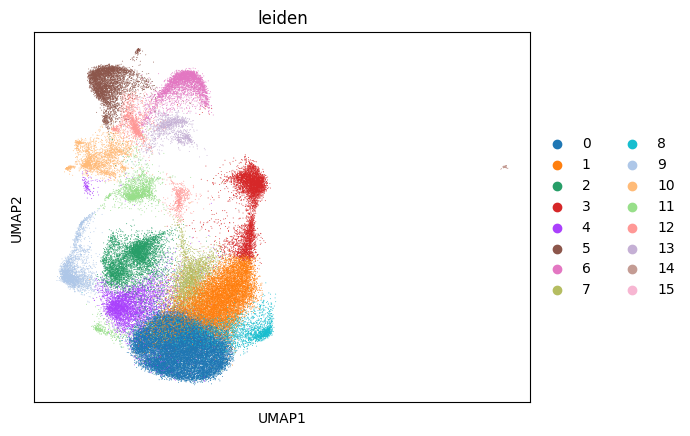

In [27]:
sc.pl.umap(adata, color="leiden")

/home/plt3/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


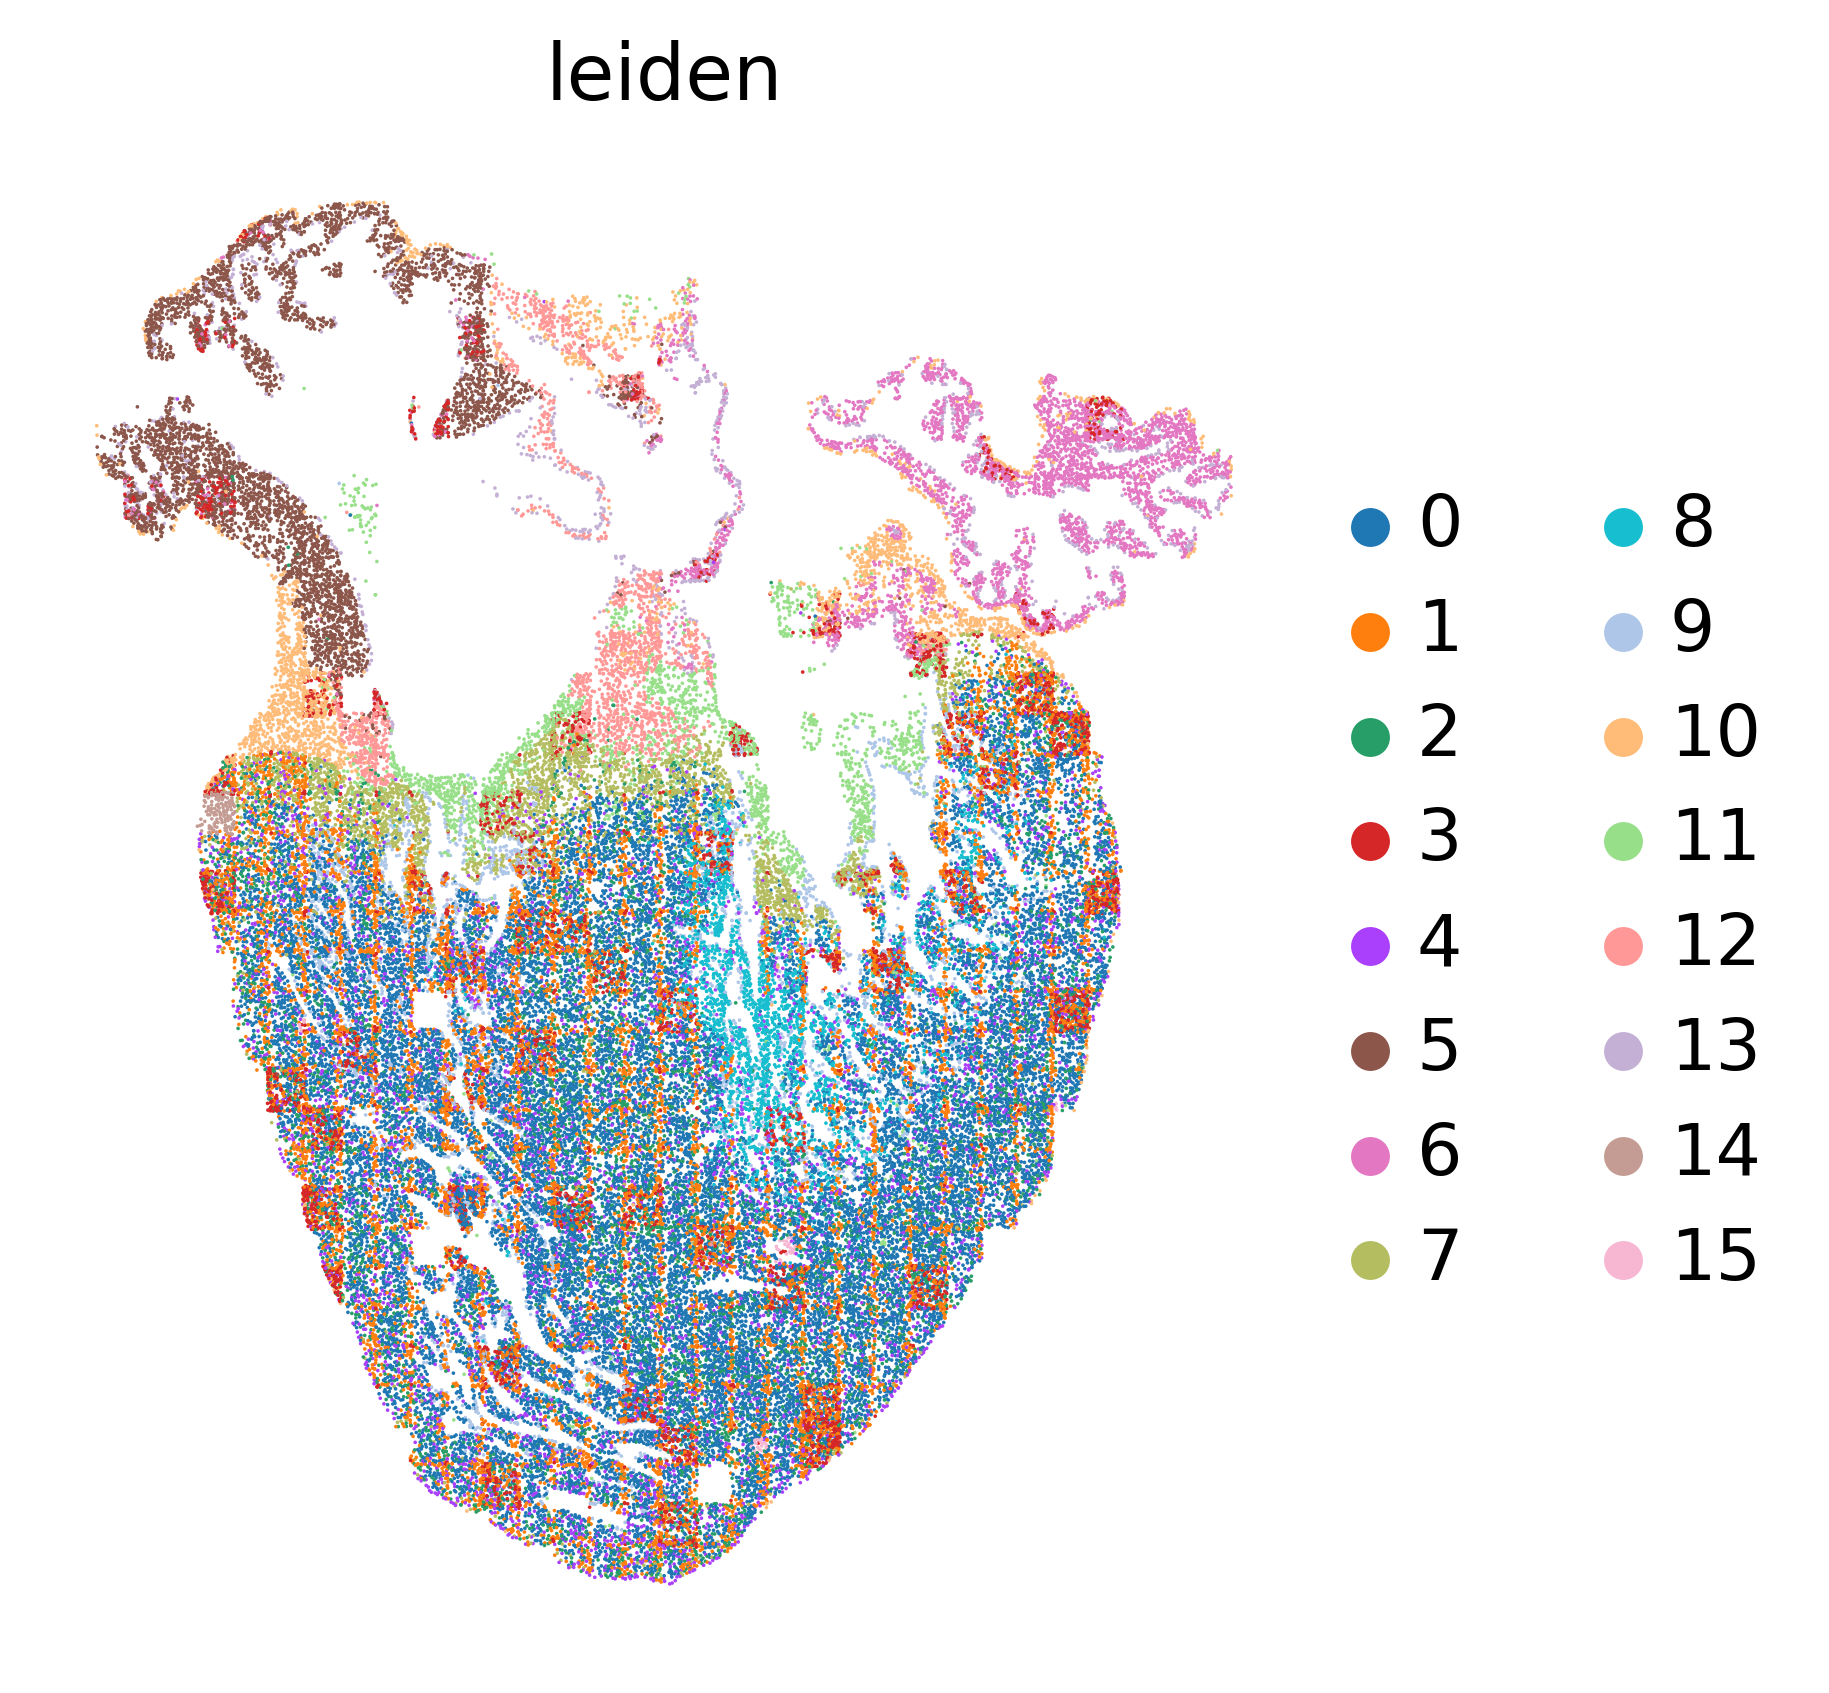

In [28]:
sc.set_figure_params(figsize=(4,5), dpi=200)
sc.pl.embedding(adata, basis="X_spatial", color="leiden", frameon=False)

In [99]:
celldata = pd.DataFrame(cellinfo, columns=np.load(save_folder+os.sep+f"finaldecs_Conv_zscan__000--.npz")["header_cells"])

In [100]:
celldata = celldata.set_index("cell_id")
celldata.index = celldata.index.astype(np.int64).astype(str)

In [101]:
celldata

volm        zc          xc          yc         xfov  \
cell_id                                                               
0          1876887.0  4.427857  270.517731  254.341400 -1746.650024   
13            5680.0  3.252113   14.545951  407.687500 -1746.650024   
14            5443.0  4.233879    9.821422  445.275208 -1746.650024   
17            6812.0  4.415737   12.889753  322.893707 -1746.650024   
20            5209.0  2.060664   41.445381  433.784027 -1746.650024   
...              ...       ...         ...         ...          ...   
761022144      210.0  9.000000   56.814285    7.485714 -1746.699951   
761022144       47.0  9.000000  266.276581  339.106384 -1746.699951   
761022144      171.0  9.000000  420.403503  206.631577 -1746.699951   
761022144      213.0  9.000000  456.361511  307.488251 -1746.699951   
761022144       92.0  9.000000  481.282623  339.152161 -1746.699951   

                 yfov  
cell_id                
0          616.799988  
13         616.799988  
14         616.799988  
17         616.799988  
20         616.799988  
...               ...  
761022144  616.849976  
761022144  616.849976  
761022144  616.849976  
761022144  616.849976  
761022144  616.849976  

[78097 rows x 6 columns]

In [104]:
"17000009" in celldata.index

False

In [105]:
celldata.index

Index(['0', '13', '14', '17', '20', '21', '22', '23', '24', '28',
       ...
       '761014976', '761014976', '761022144', '761022144', '761022144',
       '761022144', '761022144', '761022144', '761022144', '761022144'],
      dtype='object', name='cell_id', length=78097)

In [ ]:
adata.obs = celldata.loc[adata.obs_names]

In [33]:
celldata.set_index(0).loc[adata.obs_names.astype(float)][[3, 4]]

1         2           3           4            5           6
cell_id                                                                     
13.0       5680.0  3.252113   14.545951  407.687500 -1746.650024  616.799988
14.0       5443.0  4.233879    9.821422  445.275208 -1746.650024  616.799988
17.0       6812.0  4.415737   12.889753  322.893707 -1746.650024  616.799988
20.0       5209.0  2.060664   41.445381  433.784027 -1746.650024  616.799988
21.0       9062.0  5.125910   25.156258   58.509712 -1746.650024  616.799988
...           ...       ...         ...         ...          ...         ...
7624992.0   217.0  8.000000  327.115204  148.562210 -1746.699951  616.849976
7624993.0   192.0  8.000000  339.046875   17.812500 -1746.699951  616.849976
7632140.0   210.0  9.000000   56.814285    7.485714 -1746.699951  616.849976
7632141.0    47.0  9.000000  266.276581  339.106384 -1746.699951  616.849976
7632143.0   213.0  9.000000  456.361511  307.488251 -1746.699951  616.849976

[73853 rows x 6 columns]

In [35]:
df["global_y"] = -((df["x"] / 2048) * 220 - df["xfov"])
df["global_x"] = 2048 - (df["y"] / 2048) * 220 - df["yfov"]

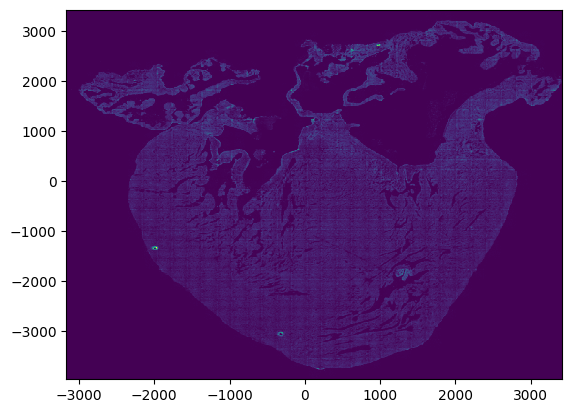

In [36]:
plt.hist2d(df["global_x"], df["global_y"], bins=512);

In [ ]:
df["gene"] = genes

In [ ]:
df

In [136]:
df[df["color"]==2]["gene"].value_counts()[:50]

FBN2        2861147
COL5A2      2489902
HAND2       2351160
APOE        1491841
MAZ         1450899
GAS1        1277797
FLRT2       1147651
PCDH7       1115447
VCAN        1047766
ECE1         988717
PKP2         936778
CNN1         909226
FILIP1L      906342
TRPM3        764447
UHRF1        752350
RAMP1        721469
DPYSL3       680309
LRP1         666810
KCNH2        645950
SOX9         642380
GJA5         605850
MCM7         592258
MECOM        498013
FMOD         497252
CBLN2        494398
GAS7         470101
ADGRL1       451210
NR2F2        435150
BRINP3       401750
TENM2        386606
PROX1        368996
PRRX1        357171
INHBA        339346
TSPO         308521
DLK1         288725
BMP2         276150
TMEM176B     273808
ELAVL2       260634
LUM          252300
COL26A1      248631
TSHZ2        236674
MKI67        228016
TBXAS1       226160
CASQ2        224713
F13A1        214990
IRX2         206484
OAF          195750
KCNJ8        192894
LEPR         186594
ASPN         164157


In [137]:
subset = df[df["gene"] == "GJA5"]
print(len(subset), subset.iloc[0]["color"])

605850 2.0


(-3144.2783203125, 3413.56103515625, -3953.946533203125, 3419.860595703125)

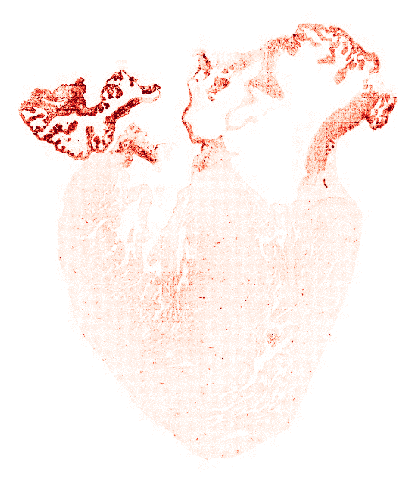

In [138]:
plt.figure(figsize=(5,6))
plt.hist2d(subset["global_x"], subset["global_y"], bins=512, cmin=1, cmap="Reds", vmax=50);
plt.axis("off")

In [7]:
list(np.load(save_folder+os.sep+"finaldecs_Conv_zscan__415--.npz").keys())

['XF', 'genes', 'cellinfo', 'header_cells', 'header']

In [10]:
np.load(save_folder+os.sep+"finaldecs_Conv_zscan__415--.npz")["header"]

array(['z', 'x', 'y', 'abs_brightness', 'cor', 'brightness', 'color',
       'mean_bightness_variation', 'mean_distance_variation',
       'index_from_XH_pruned', 'score', 'cell_id', 'ifov', 'iset', 'xfov',
       'yfov'], dtype='<U24')

In [4]:
np.load(save_folder+os.sep+"finaldecs_Conv_zscan__415--.npz")["XF"][:,:3]

array([[   8.7645035,  445.32626  ,  526.6375   ],
       [   9.066172 ,  484.6794   ,  434.97443  ],
       [  10.116356 ,   89.74771  ,  400.45206  ],
       ...,
       [   7.554426 , 1630.5582   , 1801.207    ],
       [  23.096582 , 1700.2773   , 1763.5547   ],
       [  23.767939 , 1682.1523   , 1586.0273   ]], dtype=float32)

In [11]:
import pickle
pickle.load(open(dec.drift_fl, "rb"))[4]

IndexError: list index out of range

In [ ]:
icds,ncds = np.unique(dec.icodesN[dec.scoreA>dec.th],return_counts=True)
#good_igns = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' not in gn.lower()]
dec.gns_names[icds][np.argsort(ncds)[::-1]]

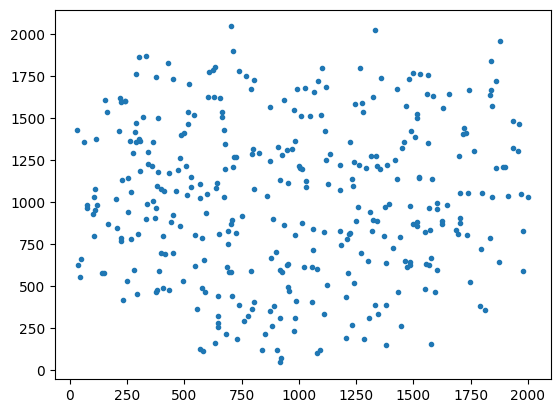

In [27]:
gene = 'MYH11'
import matplotlib.pylab as plt
gns = list(dec.gns_names)
ign = gns.index(gene)
keep_th  = dec.scoreA>dec.th
icodesN = dec.icodesN[keep_th]
is_gene = icodesN==ign
X_pruned = dec.XH_pruned[keep_th][is_gene]
X = np.mean(X_pruned,axis=1)
X_pruned.shape
plt.figure()
plt.plot(X[:,1],X[:,2],'.')
plt.show()

In [30]:
im = cv2.imread(r'/mnt/merfish9/20230919_R128_N5S1MER/H17_Myh6_Myh7_B_col0_annot.png')

In [ ]:
plt.figure(figsize=(50,50))
plt.imshow(im)

In [13]:
??plot_statistics

Signature: plot_statistics(dec)
Docstring: <no docstring>
Source:   
def plot_statistics(dec):
    if hasattr(dec,'im_segm_'):
        ncells = len(np.unique(dec.im_segm_))-1
    else:
        ncells = 1
    icds,ncds = np.unique(dec.icodesN[dec.scoreA>dec.th],return_counts=True)
    good_igns = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' not in gn.lower()]
    kp = np.in1d(icds,good_igns)
    ncds = ncds/ncells
    plt.figure()
    plt.xlabel('Genes')
    plt.plot(icds[kp],ncds[kp],label='genes')
    plt.plot(icds[~kp],ncds[~kp],label='blank')
    plt.ylabel('Number of molecules in the fov')
    plt.title(str(np.round(np.mean(ncds[~kp])/np.mean(ncds[kp]),3)))
    plt.legend()
File:      ~/new_merfish_pipeline/ioMicro.py
Type:      function


In [9]:
#fovs_fl = save_folder + os.sep + "fovs__" + "" + ".npy"
#np.load(fovs_fl)[0]

In [14]:
def apply_flat_field(dec,tag=r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets\med_col_raw'):
    ### load the immeds
    Icol = dec.XH_pruned[:,:,-2].astype(int)
    uIcols = np.unique(Icol)
    dec.ncols = len(uIcols)
    #save_folder=dec.save_folder#r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
    immeds = []
    for icol in range(dec.ncols):
        fl_med = tag+str(icol)+'.npz'
        if not os.path.exists(fl_med):
            fl_med = fl_med.replace('_raw','')
        dic = np.load(fl_med)
        immed,resc=dic['im'],dic['resc']
        immeds.append(immed)
    dec.immeds = np.array(immeds)
    dec.resc = resc
    
    ### renormalize the brightness according to flatfield
    XH = dec.XH_pruned
    Icol = XH[:,:,-2].astype(int)
    H = dec.XH_pruned[:,:,-3].copy()
    for icol in range(dec.ncols):
        keep = Icol==icol
        immed = dec.immeds[icol].copy()
        immed = immed/np.median(immed)
        x_,y_ = ((XH[keep][:,1:3]/dec.resc).astype(int)%immed.shape).T
        norm_ = immed[x_,y_] 
        H[keep]=H[keep]/norm_
    dec.XH_pruned[:,:,-3] = H


def main_analysisV1(fov,set_,
                   save_folder = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12',
                   save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                   save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpots',
                   drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                   segm_tag = 'A1_LamA_Nup98',redo=False,resc=[2,2,2],
                   drift_semgentation = np.array([  -2.5602207, -486.3025   ,   -5.648471 ])):


    if not os.path.exists(save_folder_all): os.makedirs(save_folder_all)
    save_fl = save_folder_all+os.sep+'saveDecodedFinalV1--'+os.path.basename(save_folder)+'--'+fov.split('.')[0]+'--'+set_+'.npz'
    dec = None
    if not os.path.exists(save_fl) or redo:
        ####### Load in the decoded spot data #############################
        #fov,set_ = 'Conv_zscan__040', '_D16' ################## Change 
        dec = decoder_simple(save_folder,fov,set_)
        dec.ncols = 3
        dec.load_decoded()
        print("Molecules size:",dec.XH_pruned.shape)
        print("Covering reaoduts:",np.unique(dec.XH_pruned[:,:,-1]))
        apply_fine_drift(dec,plt_val=True)
        #apply_flat_field(dec)
        #scoresRefT = get_score_per_color(dec)
        scoresRef = np.load(save_fl_ref,allow_pickle=True)
        get_score_withRef(dec,scoresRef,plt_val=True,gene=None,iSs = None,th_min=-10)
        dec.th=-0.5
        plot_statistics(dec)

        ####### Threhold the decoded spot data #############################
        keepf =  dec.scoreA>dec.th ### keep good score
        icodesf = dec.icodesN[keepf]
        XHfpr = dec.XH_pruned[keepf]

        ### Reorganize data  ###############################
        XHf = np.mean(XHfpr,axis=1)
        XF = XHf[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
        #zc,xc,yc,bk-7,a-6,habs-5,hn-4,h-3
        XF[:,-1] = dec.scoreA[keepf]
        XF[:,-2] = np.where(keepf)[0]
        mnD = np.mean(np.linalg.norm((XHf[:,np.newaxis]-XHfpr)[:,:,:3],axis=-1),axis=-1)
        XF[:,-3]=mnD
        mnH = np.mean(np.abs((XHf[:,np.newaxis]-XHfpr)[:,:,-3]),axis=-1)
        XF[:,-4]=mnH
        genesf = dec.gns_names[icodesf]

        ### Apply drift to match the segmentation reference ########################
        def get_drft_dic(fl_all_drift):
            drft,flds,fov_,fl_ref= np.load(fl_all_drift,allow_pickle=True)
            return {('--'.join(fld.split(os.sep)[-2:]) if '--' in os.path.basename(fld) else os.path.basename(fld)):drft_[0] 
                    for fld,drft_ in zip(flds,drft)}

        fl_all_drift = drift_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
        drft_dic_all = get_drft_dic(fl_all_drift)
        fl_all_drift = save_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
        drft_dic_group = get_drft_dic(fl_all_drift)
        key_segm = [key for key in drft_dic_all if segm_tag in key][0]
        key_align = np.intersect1d(list(drft_dic_all.keys()),list(drft_dic_group.keys()))[0]
        if drift_semgentation is None:
            drift_semgentation = drft_dic_all[key_segm]
        th1_to_h0 = drift_semgentation-drft_dic_all[key_align]
        th1_gr = drft_dic_group[key_align]
        tzxyf = th1_gr+th1_to_h0

        XF[:,:3]=XF[:,:3]-tzxyf #### do not add here

        
                
        ### Load in the current fov segmentation ######################################
        ifov = fovs.index(dec.fov)
        coords= coordsf[ifov]
        xIm,xIM,yIm,yIM = coords[0],coords[1],coords[2],coords[3]
        min_ = np.min(XF[:,:3],axis=0)
        max_ = np.max(XF[:,:3],axis=0)

        xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
        ### deal with the case of outside image
        Im = np.array([xIm,yIm])
        min_[1:]=min_[1:]-Im*(Im<0)*resc[1:]
        ### recenter
        xIm,xIM,yIm,yIM = coords[0],coords[1],coords[2],coords[3]
        xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
        XF__=XF[:,:3]-min_
        xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
        dec.im_segm_ = imfsegm[:,xIm:xIM,yIm:yIM]
        dec.XF__ = XF__
        dec.XF = XF
        dec.resc = resc

        #### get cell ids #######################
        def get_cell_id(dec,Xh,resc=[2,2,2],plot_val = False):
            if not hasattr(dec,'im_segm_'): 
                good = np.ones(len(Xh),dtype=bool)
                cells_ = np.zeros(len(Xh),dtype=int)
                return cells_,good
            im_segm = dec.im_segm_
            dec.shapesm = dec.im_segm_.shape
            Xcms = Xh[:,:3]
            Xred = np.round(Xcms/resc).astype(int)
            good = ~np.any((Xred>=dec.shapesm)|(Xred<0),axis=-1)
            Xred = Xred[good]
            if plot_val:
                v = napari.view_points(Xred,size=1.5)
                v.add_labels(im_segm)
            return im_segm[tuple(Xred.T)],good


        cell_id,good =get_cell_id(dec,XF__,resc=resc,plot_val = False)
        #XF_ = np.concatenate([XF[good],cell_id[:,np.newaxis]],axis=-1)
        genesf_ = genesf[good]
        iset = int(dec.set_.split('_D')[-1])
        ifov = int(dec.fov.split('_')[-1].split('.')[0])
        isets = np.array([iset]*len(cell_id))[:,np.newaxis]
        ifovs = np.array([ifov]*len(cell_id))[:,np.newaxis]
        cell_id = cell_id[:,np.newaxis]
        XF_ = np.concatenate([XF[good],cell_id,ifovs,isets],axis=-1)

        #get_xyfov(dec)
        ### add absolute positiuons of molecules in um
        pixel_size = np.array([0.4,0.10833,0.10833])*resc
        XF_ = XF_[:,list(np.arange(XF_.shape[-1]))+[-1,-1,-1]]
        XF_[:,-3:]=((XF_[:,:3]/resc)+[0,coords[0],coords[2]])*pixel_size
        header = ['z','x','y','abs_brightness','cor','brightness','color','mean_bightness_variation','mean_distance_variation',
                  'index_from_XH_pruned','score','cell_id','ifov','iset','z_um_abs','x_um_abs','y_um_abs']


        ##### get info for cells #########################
        if not hasattr(dec,'im_segm_'): dec.im_segm_=np.zeros(np.array([30,3000,3000])//2)
        icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
        #icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))

        cells_abs_pos = (cms+[0,coords[0],coords[2]])*pixel_size

        cellinfo = cms[:,[0,0,0,1,2,0,0,0]]
        cellinfo[:,0]=icells
        cellinfo[:,1]=vols
        cellinfo[:,-3:]=cells_abs_pos

        header_cells = ['cell_id','volm','zc','xc','yc','z_um_abs','x_um_abs','y_um_abs']
        plt.close('all')

        if True:
            np.savez_compressed(save_fl,XF=XF_.astype(np.float32),
                                genes = genesf_,cellinfo=cellinfo.astype(np.float32),header_cells=header_cells,header=header)
        print("Finished",save_fl)
    return dec

In [3]:
set_ = '_D14'
dic_ = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\imfsegm--'+set_+'.npz')################
imfsegm = dic_['imfsegm']
coordsf=dic_['coordsf']
resc = dic_['resc']
dic = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\pos_um_fovs--'+set_+'.npz')##################
pos=dic['pos']
fls=dic['fls']
fovs = [os.path.basename(fl).split('--')[0]for fl in fls]
set_ = '_'+os.path.basename(fls[0]).split('--')[1].split('_')[-1]

In [4]:
save_folders = [r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12',
                r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34',
                r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2']
for fld in save_folders:
    print(os.path.exists(fld))

True
True
True
True
True
True


In [5]:
paramaters = [(fov,set_,save_folder)for fov in fovs for save_folder in save_folders]
len(paramaters)

1536

In [15]:
fov,set_,save_folder = paramaters[1000]
main_analysisV1(fov,set_,
                       save_folder = save_folder,
                       save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                       save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                       drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                       segm_tag = 'A1_LamA_Nup98')

Loaded decoded: -3.09335994720459
Molecules size: (2394170, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  8.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__166--_D14.npz



  0%|                                                                                         | 0/1536 [00:00<?, ?it/s]

Loaded decoded: -1.5174291133880615
Molecules size: (1145208, 4, 10)
Covering reaoduts: [ 3.   4.   5.   9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.  16.
 17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
 31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
 45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 13.46it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
  0%|                                                                               | 1/1536 [00:17<7:24:38, 17.38s/it]

Failed at: Conv_zscan__000 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -1.0783743858337402
Molecules size: (791715, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  0%|                                                                               | 2/1536 [00:40<8:50:47, 20.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__000--_D14.npz
Loaded decoded: -0.4454841613769531
Molecules size: (291856, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  0%|▏                                                                              | 3/1536 [00:56<7:56:38, 18.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__000--_D14.npz
Loaded decoded: -1.2701003551483154
Molecules size: (997676, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  0%|▏                                                                              | 4/1536 [01:17<8:22:48, 19.69s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__000--_D14.npz
Loaded decoded: -1.1230275630950928
Molecules size: (871247, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  0%|▎                                                                              | 5/1536 [01:48<9:59:28, 23.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__000--_D14.npz
Loaded decoded: -0.5585439205169678
Molecules size: (294293, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  0%|▎                                                                              | 6/1536 [02:04<8:55:53, 21.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__000--_D14.npz
Loaded decoded: -28.630412817001343
Molecules size: (20073245, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.58it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__001--_D14.npz



  0%|▎                                                                             | 7/1536 [04:42<27:59:25, 65.90s/it]

Loaded decoded: -15.566247940063477
Molecules size: (11351715, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



  1%|▍                                                                             | 8/1536 [06:37<34:38:36, 81.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__001--_D14.npz
Loaded decoded: -10.400361776351929
Molecules size: (4459169, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|▍                                                                             | 9/1536 [07:34<31:20:37, 73.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__001--_D14.npz
Loaded decoded: -29.177167415618896
Molecules size: (17136128, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__001--_D14.npz



  1%|▌                                                                            | 10/1536 [10:03<41:04:34, 96.90s/it]

Loaded decoded: -17.97081470489502
Molecules size: (13506401, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   7.
  8.   9.  10.  11.  12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5
 24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.
 38.  39.  40.  41.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:29<00:00,  1.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__001--_D14.npz



  1%|▌                                                                           | 11/1536 [11:57<43:19:08, 102.26s/it]

Loaded decoded: -4.933014631271362
Molecules size: (3448094, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▌                                                                            | 12/1536 [12:41<35:43:30, 84.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__001--_D14.npz
Loaded decoded: -15.62819218635559
Molecules size: (10700954, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.50it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__002--_D14.npz



  1%|▋                                                                            | 13/1536 [14:28<38:41:37, 91.46s/it]

Loaded decoded: -8.359662532806396
Molecules size: (5867943, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



  1%|▋                                                                            | 14/1536 [15:31<35:01:37, 82.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__002--_D14.npz
Loaded decoded: -2.824228048324585
Molecules size: (2007396, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



  1%|▊                                                                            | 15/1536 [16:03<28:25:55, 67.30s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__002--_D14.npz
Loaded decoded: -19.616508960723877
Molecules size: (8218150, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.33it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__002--_D14.npz



  1%|▊                                                                            | 16/1536 [17:25<30:19:32, 71.82s/it]

Loaded decoded: -8.2637038230896
Molecules size: (6473766, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.
 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
 33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.71it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__002--_D14.npz



  1%|▊                                                                            | 17/1536 [18:27<29:01:14, 68.78s/it]

Loaded decoded: -2.600464105606079
Molecules size: (1870643, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▉                                                                            | 18/1536 [18:56<24:03:22, 57.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__002--_D14.npz
Loaded decoded: -24.596121072769165
Molecules size: (14462342, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.98it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__003--_D14.npz



  1%|▉                                                                            | 19/1536 [20:56<31:53:56, 75.70s/it]

Loaded decoded: -10.354946613311768
Molecules size: (6235641, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



  1%|█                                                                            | 20/1536 [22:12<32:01:44, 76.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__003--_D14.npz
Loaded decoded: -3.123302698135376
Molecules size: (1942952, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|█                                                                            | 21/1536 [22:53<27:29:06, 65.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__003--_D14.npz
Loaded decoded: -10.556443691253662
Molecules size: (7077861, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.38it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__003--_D14.npz



  1%|█                                                                            | 22/1536 [24:07<28:36:00, 68.01s/it]

Loaded decoded: -8.760807514190674
Molecules size: (5817076, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.84it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__003--_D14.npz



  1%|█▏                                                                           | 23/1536 [25:05<27:17:38, 64.94s/it]

Loaded decoded: -3.066361904144287
Molecules size: (1907452, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▏                                                                           | 24/1536 [25:48<24:33:57, 58.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__003--_D14.npz
Loaded decoded: -16.32492232322693
Molecules size: (3878860, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▎                                                                           | 25/1536 [26:41<23:46:37, 56.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__004--_D14.npz
Loaded decoded: -2.023695230484009
Molecules size: (1471710, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▎                                                                           | 26/1536 [27:32<23:03:28, 54.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__004--_D14.npz
Loaded decoded: -0.4590601921081543
Molecules size: (282214, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▎                                                                           | 27/1536 [28:02<19:57:20, 47.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__004--_D14.npz
Loaded decoded: -2.5166614055633545
Molecules size: (1824689, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▍                                                                           | 28/1536 [28:36<18:09:39, 43.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__004--_D14.npz
Loaded decoded: -2.7369141578674316
Molecules size: (1490005, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▍                                                                           | 29/1536 [29:04<16:19:26, 39.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__004--_D14.npz
Loaded decoded: -0.35444092750549316
Molecules size: (231970, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.5  4.5  5.5  6.   6.5  7.   7.5  8.
  8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.
 22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.
 29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.  37.  38.  39.
 40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▌                                                                           | 30/1536 [29:33<15:01:40, 35.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__004--_D14.npz
Loaded decoded: -21.99279475212097
Molecules size: (14257603, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.80it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__005--_D14.npz



  2%|█▌                                                                           | 31/1536 [31:38<26:13:34, 62.73s/it]

Loaded decoded: -10.347142696380615
Molecules size: (6900676, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.48it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__005--_D14.npz



  2%|█▌                                                                           | 32/1536 [32:49<27:13:46, 65.18s/it]

Loaded decoded: -6.8012895584106445
Molecules size: (2281787, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



  2%|█▋                                                                           | 33/1536 [33:26<23:38:55, 56.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__005--_D14.npz
Loaded decoded: -10.480061769485474
Molecules size: (7632379, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__005--_D14.npz



  2%|█▋                                                                           | 34/1536 [34:34<25:04:17, 60.09s/it]

Loaded decoded: -8.562689781188965
Molecules size: (6311211, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▊                                                                           | 35/1536 [35:33<24:53:02, 59.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__005--_D14.npz
Loaded decoded: -3.1207797527313232
Molecules size: (2194748, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▊                                                                           | 36/1536 [36:05<21:23:33, 51.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__005--_D14.npz
Loaded decoded: -9.63106369972229
Molecules size: (7021811, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▊                                                                           | 37/1536 [37:03<22:11:26, 53.29s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__006--_D14.npz
Loaded decoded: -3.9236440658569336
Molecules size: (2998978, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



  2%|█▉                                                                           | 38/1536 [37:37<19:50:06, 47.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__006--_D14.npz
Loaded decoded: -1.2033898830413818
Molecules size: (843886, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|█▉                                                                           | 39/1536 [37:57<16:22:25, 39.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__006--_D14.npz
Loaded decoded: -4.600426435470581
Molecules size: (3573578, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██                                                                           | 40/1536 [38:35<16:07:46, 38.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__006--_D14.npz
Loaded decoded: -3.660471200942993
Molecules size: (2877735, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██                                                                           | 41/1536 [39:08<15:28:37, 37.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__006--_D14.npz
Loaded decoded: -1.2633087635040283
Molecules size: (820516, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██                                                                           | 42/1536 [39:28<13:15:10, 31.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__006--_D14.npz
Loaded decoded: -0.30801987648010254
Molecules size: (131237, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 15. 16. 17. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 67.30it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
  3%|██▏                                                                          | 43/1536 [39:37<10:28:10, 25.24s/it]

Failed at: Conv_zscan__007 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.08983254432678223
Molecules size: (3294, 4, 10)
Covering reaoduts: [24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 43. 44. 45. 46. 47.]



  3%|██▏                                                                           | 44/1536 [39:38<7:20:20, 17.71s/it]

Failed at: Conv_zscan__007 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.11778950691223145
Molecules size: (22224, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▎                                                                           | 45/1536 [39:48<6:24:20, 15.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__007--_D14.npz
Loaded decoded: -0.3681330680847168
Molecules size: (187493, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44.]



  3%|██▎                                                                           | 46/1536 [40:02<6:16:04, 15.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__007--_D14.npz
Loaded decoded: -0.14154767990112305
Molecules size: (66774, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▍                                                                           | 47/1536 [40:12<5:32:54, 13.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__007--_D14.npz
Loaded decoded: -0.32613682746887207
Molecules size: (43830, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██▍                                                                           | 48/1536 [40:12<3:56:39,  9.54s/it]

Failed at: Conv_zscan__007 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.15380120277404785
Molecules size: (38974, 4, 10)
Covering reaoduts: [ 6.   7.   8.   9.5 10.5 11.5 21.  22.  23.  24.  25.  26.  27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



  3%|██▍                                                                           | 49/1536 [40:12<2:48:20,  6.79s/it]

Failed at: Conv_zscan__008 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.09311699867248535
Molecules size: (2093, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.
 33. 34. 35. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1875.36it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
  3%|██▌                                                                           | 50/1536 [40:18<2:41:10,  6.51s/it]

Failed at: Conv_zscan__008 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.11596393585205078
Molecules size: (9931, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▌                                                                           | 51/1536 [40:28<3:07:41,  7.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__008--_D14.npz
Loaded decoded: -0.20087051391601562
Molecules size: (115821, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▋                                                                           | 52/1536 [40:40<3:33:37,  8.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__008--_D14.npz
Loaded decoded: -0.09201717376708984
Molecules size: (7985, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1383.59it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
  3%|██▋                                                                           | 53/1536 [40:45<3:11:17,  7.74s/it]

Failed at: Conv_zscan__008 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.16431760787963867
Molecules size: (18729, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  34.  35.  36.  37.
 38.  40.  41.  45.  46.  47. ]



  4%|██▋                                                                           | 54/1536 [40:45<2:15:37,  5.49s/it]

Failed at: Conv_zscan__008 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -9.38689398765564
Molecules size: (6874433, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▊                                                                           | 55/1536 [41:43<8:43:25, 21.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__009--_D14.npz
Loaded decoded: -4.549211740493774
Molecules size: (2070784, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|██▊                                                                           | 56/1536 [42:11<9:31:49, 23.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__009--_D14.npz
Loaded decoded: -1.434941291809082
Molecules size: (653028, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|██▉                                                                           | 57/1536 [42:31<9:04:53, 22.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__009--_D14.npz
Loaded decoded: -3.5549492835998535
Molecules size: (2684189, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|██▉                                                                           | 58/1536 [43:00<9:55:54, 24.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__009--_D14.npz
Loaded decoded: -2.5330145359039307
Molecules size: (1989149, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|██▉                                                                          | 59/1536 [43:27<10:16:10, 25.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__009--_D14.npz
Loaded decoded: -0.7444241046905518
Molecules size: (575203, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  31.  32.  33.  34.  35.  36.  37.  38.  39.
 40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███                                                                           | 60/1536 [43:45<9:23:32, 22.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__009--_D14.npz
Loaded decoded: -13.572791814804077
Molecules size: (8090140, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███                                                                          | 61/1536 [44:55<15:11:36, 37.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__010--_D14.npz
Loaded decoded: -3.666221857070923
Molecules size: (2720028, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███                                                                          | 62/1536 [45:28<14:39:25, 35.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__010--_D14.npz
Loaded decoded: -1.303515911102295
Molecules size: (991272, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|███▏                                                                         | 63/1536 [45:49<12:49:36, 31.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__010--_D14.npz
Loaded decoded: -4.579635381698608
Molecules size: (3670001, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███▏                                                                         | 64/1536 [46:26<13:30:52, 33.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__010--_D14.npz
Loaded decoded: -3.5344507694244385
Molecules size: (2779971, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███▎                                                                         | 65/1536 [46:55<13:01:57, 31.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__010--_D14.npz
Loaded decoded: -1.3730499744415283
Molecules size: (701453, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███▎                                                                         | 66/1536 [47:15<11:33:19, 28.30s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__010--_D14.npz
Loaded decoded: -13.532885551452637
Molecules size: (8376731, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███▎                                                                         | 67/1536 [48:27<16:56:26, 41.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__011--_D14.npz
Loaded decoded: -4.874358415603638
Molecules size: (3536702, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███▍                                                                         | 68/1536 [49:06<16:38:29, 40.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__011--_D14.npz
Loaded decoded: -1.8688812255859375
Molecules size: (1230013, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|███▍                                                                         | 69/1536 [49:30<14:31:35, 35.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__011--_D14.npz
Loaded decoded: -10.272217512130737
Molecules size: (4534503, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▌                                                                         | 70/1536 [50:21<16:26:27, 40.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__011--_D14.npz
Loaded decoded: -7.0488057136535645
Molecules size: (3637776, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▌                                                                         | 71/1536 [51:04<16:44:39, 41.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__011--_D14.npz
Loaded decoded: -1.4798450469970703
Molecules size: (1054691, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▌                                                                         | 72/1536 [51:24<14:04:51, 34.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__011--_D14.npz
Loaded decoded: -2.880239486694336
Molecules size: (2214907, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▋                                                                         | 73/1536 [51:52<13:19:29, 32.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__012--_D14.npz
Loaded decoded: -1.166599988937378
Molecules size: (865009, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▋                                                                         | 74/1536 [52:12<11:45:51, 28.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__012--_D14.npz
Loaded decoded: -0.7460625171661377
Molecules size: (397796, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▊                                                                         | 75/1536 [52:29<10:17:58, 25.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__012--_D14.npz
Loaded decoded: -1.6566112041473389
Molecules size: (1245400, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▊                                                                          | 76/1536 [52:51<9:55:13, 24.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__012--_D14.npz
Loaded decoded: -1.163621425628662
Molecules size: (939880, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▉                                                                          | 77/1536 [53:11<9:19:56, 23.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__012--_D14.npz
Loaded decoded: -0.32244038581848145
Molecules size: (234268, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▉                                                                          | 78/1536 [53:24<8:02:43, 19.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__012--_D14.npz
Loaded decoded: -11.420092344284058
Molecules size: (8368782, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▉                                                                         | 79/1536 [54:32<13:53:32, 34.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__013--_D14.npz
Loaded decoded: -4.830709934234619
Molecules size: (3646612, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



  5%|████                                                                         | 80/1536 [55:11<14:28:35, 35.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__013--_D14.npz
Loaded decoded: -1.9829425811767578
Molecules size: (1295549, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|████                                                                         | 81/1536 [55:36<13:09:50, 32.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__013--_D14.npz
Loaded decoded: -5.866626262664795
Molecules size: (4536024, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|████                                                                         | 82/1536 [56:16<14:02:54, 34.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__013--_D14.npz
Loaded decoded: -4.563901901245117
Molecules size: (3645613, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|████▏                                                                        | 83/1536 [56:54<14:23:07, 35.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__013--_D14.npz
Loaded decoded: -1.917025089263916
Molecules size: (984532, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|████▏                                                                        | 84/1536 [57:16<12:44:13, 31.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__013--_D14.npz
Loaded decoded: -3.908506155014038
Molecules size: (2624975, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▎                                                                        | 85/1536 [57:45<12:26:46, 30.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__014--_D14.npz
Loaded decoded: -1.178133487701416
Molecules size: (786724, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▎                                                                        | 86/1536 [58:05<11:05:42, 27.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__014--_D14.npz
Loaded decoded: -0.3145453929901123
Molecules size: (194387, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▍                                                                         | 87/1536 [58:19<9:32:21, 23.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__014--_D14.npz
Loaded decoded: -1.1915874481201172
Molecules size: (932558, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▍                                                                         | 88/1536 [58:40<9:06:51, 22.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__014--_D14.npz
Loaded decoded: -0.9828059673309326
Molecules size: (675060, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▌                                                                         | 89/1536 [58:56<8:20:52, 20.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__014--_D14.npz
Loaded decoded: -0.3479158878326416
Molecules size: (218602, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▌                                                                         | 90/1536 [59:11<7:40:16, 19.10s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__014--_D14.npz
Loaded decoded: -3.022049903869629
Molecules size: (2137550, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▌                                                                         | 91/1536 [59:40<8:49:07, 21.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__015--_D14.npz
Loaded decoded: -1.0422084331512451
Molecules size: (819814, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▌                                                                       | 92/1536 [1:00:00<8:34:02, 21.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__015--_D14.npz
Loaded decoded: -0.3781735897064209
Molecules size: (244229, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▌                                                                       | 93/1536 [1:00:12<7:30:44, 18.74s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__015--_D14.npz
Loaded decoded: -1.3180551528930664
Molecules size: (1031650, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▋                                                                       | 94/1536 [1:00:33<7:44:29, 19.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__015--_D14.npz
Loaded decoded: -1.0269756317138672
Molecules size: (852481, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▋                                                                       | 95/1536 [1:00:53<7:46:42, 19.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__015--_D14.npz
Loaded decoded: -0.4807753562927246
Molecules size: (270630, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▊                                                                       | 96/1536 [1:01:08<7:18:42, 18.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__015--_D14.npz
Loaded decoded: -17.163389921188354
Molecules size: (10694019, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▋                                                                      | 97/1536 [1:02:36<15:36:13, 39.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__016--_D14.npz
Loaded decoded: -6.210779428482056
Molecules size: (4568618, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▊                                                                      | 98/1536 [1:03:22<16:23:58, 41.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__016--_D14.npz
Loaded decoded: -2.16884183883667
Molecules size: (1559314, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▊                                                                      | 99/1536 [1:03:47<14:33:01, 36.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__016--_D14.npz
Loaded decoded: -7.985642671585083
Molecules size: (5979432, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|████▊                                                                     | 100/1536 [1:04:40<16:27:24, 41.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__016--_D14.npz
Loaded decoded: -6.4616358280181885
Molecules size: (4937989, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|████▊                                                                     | 101/1536 [1:05:27<17:07:00, 42.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__016--_D14.npz
Loaded decoded: -1.9948630332946777
Molecules size: (1371350, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|████▉                                                                     | 102/1536 [1:05:51<14:53:58, 37.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__016--_D14.npz
Loaded decoded: -1.3604021072387695
Molecules size: (946813, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|████▉                                                                     | 103/1536 [1:06:12<12:53:57, 32.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__017--_D14.npz
Loaded decoded: -0.6852970123291016
Molecules size: (492745, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████                                                                     | 104/1536 [1:06:30<11:12:37, 28.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__017--_D14.npz
Loaded decoded: -0.34154558181762695
Molecules size: (221530, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|█████▏                                                                     | 105/1536 [1:06:43<9:23:10, 23.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__017--_D14.npz
Loaded decoded: -0.9491798877716064
Molecules size: (701836, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▏                                                                     | 106/1536 [1:07:04<9:01:22, 22.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__017--_D14.npz
Loaded decoded: -0.7012052536010742
Molecules size: (566962, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▏                                                                     | 107/1536 [1:07:23<8:38:08, 21.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__017--_D14.npz
Loaded decoded: -0.3463766574859619
Molecules size: (205676, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████▎                                                                     | 108/1536 [1:07:36<7:32:34, 19.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__017--_D14.npz
Loaded decoded: -2.2511963844299316
Molecules size: (1529856, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████▎                                                                     | 109/1536 [1:08:05<8:44:27, 22.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__018--_D14.npz
Loaded decoded: -1.2714428901672363
Molecules size: (588708, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▎                                                                     | 110/1536 [1:08:26<8:34:20, 21.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__018--_D14.npz
Loaded decoded: -0.3782217502593994
Molecules size: (212929, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|█████▍                                                                     | 111/1536 [1:08:42<7:52:28, 19.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__018--_D14.npz
Loaded decoded: -1.0063295364379883
Molecules size: (763783, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▍                                                                     | 112/1536 [1:09:02<7:53:15, 19.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__018--_D14.npz
Loaded decoded: -0.7958343029022217
Molecules size: (618315, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▌                                                                     | 113/1536 [1:09:22<7:53:37, 19.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__018--_D14.npz
Loaded decoded: -0.3546173572540283
Molecules size: (210604, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████▌                                                                     | 114/1536 [1:09:37<7:21:39, 18.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__018--_D14.npz
Loaded decoded: -10.695972442626953
Molecules size: (7686769, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████▌                                                                    | 115/1536 [1:11:05<15:32:09, 39.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__019--_D14.npz
Loaded decoded: -4.031280517578125
Molecules size: (2814306, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|█████▌                                                                    | 116/1536 [1:11:47<15:47:22, 40.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__019--_D14.npz
Loaded decoded: -1.250483512878418
Molecules size: (721733, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|█████▋                                                                    | 117/1536 [1:12:08<13:36:36, 34.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__019--_D14.npz
Loaded decoded: -5.013417720794678
Molecules size: (3612915, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|█████▋                                                                    | 118/1536 [1:12:54<14:58:07, 38.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__019--_D14.npz
Loaded decoded: -3.5644407272338867
Molecules size: (2689224, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|█████▋                                                                    | 119/1536 [1:13:35<15:16:22, 38.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__019--_D14.npz
Loaded decoded: -1.2469866275787354
Molecules size: (846980, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  8%|█████▊                                                                    | 120/1536 [1:13:58<13:25:57, 34.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__019--_D14.npz
Loaded decoded: -34.88915991783142
Molecules size: (22013402, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.39it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__020--_D14.npz



  8%|█████▊                                                                    | 121/1536 [1:17:52<36:55:09, 93.93s/it]

Loaded decoded: -21.46200966835022
Molecules size: (14237603, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:39<00:00,  1.22it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__020--_D14.npz



  8%|█████▊                                                                   | 122/1536 [1:20:54<47:16:08, 120.35s/it]

Loaded decoded: -5.6229166984558105
Molecules size: (3703060, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|█████▊                                                                   | 123/1536 [1:21:50<39:43:33, 101.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__020--_D14.npz
Loaded decoded: -23.096662282943726
Molecules size: (16333444, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.36it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__020--_D14.npz



  8%|█████▉                                                                   | 124/1536 [1:25:04<50:37:53, 129.09s/it]

Loaded decoded: -15.998714923858643
Molecules size: (11105332, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.29it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__020--_D14.npz



  8%|█████▉                                                                   | 125/1536 [1:27:12<50:28:31, 128.78s/it]

Loaded decoded: -6.039405345916748
Molecules size: (3905143, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  8%|█████▉                                                                   | 126/1536 [1:28:12<42:17:44, 107.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__020--_D14.npz
Loaded decoded: -12.171353816986084
Molecules size: (4507579, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  8%|██████                                                                    | 127/1536 [1:29:21<37:40:51, 96.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__021--_D14.npz
Loaded decoded: -2.62947678565979
Molecules size: (1751956, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|██████▏                                                                   | 128/1536 [1:29:54<30:12:34, 77.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__021--_D14.npz
Loaded decoded: -0.8018968105316162
Molecules size: (530895, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|██████▏                                                                   | 129/1536 [1:30:15<23:38:29, 60.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__021--_D14.npz
Loaded decoded: -4.204798936843872
Molecules size: (2289534, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|██████▎                                                                   | 130/1536 [1:30:57<21:24:31, 54.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__021--_D14.npz
Loaded decoded: -2.6407811641693115
Molecules size: (1844206, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▎                                                                   | 131/1536 [1:31:33<19:10:37, 49.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__021--_D14.npz
Loaded decoded: -0.8245890140533447
Molecules size: (562364, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▎                                                                   | 132/1536 [1:31:55<16:01:45, 41.10s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__021--_D14.npz
Loaded decoded: -5.910183429718018
Molecules size: (2789295, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▍                                                                   | 133/1536 [1:32:39<16:22:29, 42.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__022--_D14.npz
Loaded decoded: -1.700146198272705
Molecules size: (1113746, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▍                                                                   | 134/1536 [1:33:08<14:52:45, 38.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__022--_D14.npz
Loaded decoded: -0.5104827880859375
Molecules size: (333361, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  9%|██████▌                                                                   | 135/1536 [1:33:27<12:36:07, 32.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__022--_D14.npz
Loaded decoded: -2.8585989475250244
Molecules size: (1491337, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▌                                                                   | 136/1536 [1:33:56<12:11:30, 31.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__022--_D14.npz
Loaded decoded: -1.5948305130004883
Molecules size: (1188308, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▌                                                                   | 137/1536 [1:34:21<11:28:14, 29.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__022--_D14.npz
Loaded decoded: -0.5770955085754395
Molecules size: (367980, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▋                                                                   | 138/1536 [1:34:39<10:01:33, 25.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__022--_D14.npz
Loaded decoded: -1.0377931594848633
Molecules size: (669554, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▊                                                                    | 139/1536 [1:35:00<9:32:05, 24.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__023--_D14.npz
Loaded decoded: -0.6166858673095703
Molecules size: (269994, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▊                                                                    | 140/1536 [1:35:18<8:47:44, 22.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__023--_D14.npz
Loaded decoded: -0.2070021629333496
Molecules size: (93542, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  9%|██████▉                                                                    | 141/1536 [1:35:34<7:58:13, 20.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__023--_D14.npz
Loaded decoded: -0.5145385265350342
Molecules size: (367402, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▉                                                                    | 142/1536 [1:35:51<7:29:21, 19.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__023--_D14.npz
Loaded decoded: -0.47771358489990234
Molecules size: (340424, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▉                                                                    | 143/1536 [1:36:07<7:08:29, 18.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__023--_D14.npz
Loaded decoded: -0.1996321678161621
Molecules size: (108314, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|███████                                                                    | 144/1536 [1:36:23<6:51:47, 17.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__023--_D14.npz
Loaded decoded: -2.017897367477417
Molecules size: (977669, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|███████                                                                    | 145/1536 [1:36:47<7:33:48, 19.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__024--_D14.npz
Loaded decoded: -0.5721821784973145
Molecules size: (431744, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▏                                                                   | 146/1536 [1:37:08<7:40:35, 19.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__024--_D14.npz
Loaded decoded: -0.2501082420349121
Molecules size: (106030, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████▏                                                                   | 147/1536 [1:37:23<7:09:19, 18.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__024--_D14.npz
Loaded decoded: -0.7862677574157715
Molecules size: (543699, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▏                                                                   | 148/1536 [1:37:40<6:57:23, 18.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__024--_D14.npz
Loaded decoded: -0.6073739528656006
Molecules size: (420562, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▎                                                                   | 149/1536 [1:37:56<6:41:44, 17.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__024--_D14.npz
Loaded decoded: -0.24147868156433105
Molecules size: (115687, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▎                                                                   | 150/1536 [1:38:09<6:11:01, 16.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__024--_D14.npz
Loaded decoded: -4.639991998672485
Molecules size: (3165698, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▎                                                                   | 151/1536 [1:38:50<9:02:45, 23.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__025--_D14.npz
Loaded decoded: -2.3098199367523193
Molecules size: (1670108, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▍                                                                   | 152/1536 [1:39:15<9:15:45, 24.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__025--_D14.npz
Loaded decoded: -0.7945985794067383
Molecules size: (497699, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████▍                                                                   | 153/1536 [1:39:36<8:51:23, 23.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__025--_D14.npz
Loaded decoded: -3.1897659301757812
Molecules size: (2336353, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▌                                                                   | 154/1536 [1:40:08<9:52:39, 25.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__025--_D14.npz
Loaded decoded: -2.8154072761535645
Molecules size: (1700088, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▍                                                                  | 155/1536 [1:40:35<10:01:03, 26.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__025--_D14.npz
Loaded decoded: -0.9441769123077393
Molecules size: (563408, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▌                                                                   | 156/1536 [1:40:53<9:04:19, 23.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__025--_D14.npz
Loaded decoded: -11.611851930618286
Molecules size: (7705065, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__026--_D14.npz



 10%|███████▌                                                                  | 157/1536 [1:42:01<14:13:36, 37.14s/it]

Loaded decoded: -5.693718671798706
Molecules size: (3560022, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▌                                                                  | 158/1536 [1:42:41<14:30:29, 37.90s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__026--_D14.npz
Loaded decoded: -2.3617782592773438
Molecules size: (1102673, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████▋                                                                  | 159/1536 [1:43:06<13:05:04, 34.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__026--_D14.npz
Loaded decoded: -6.7532799243927
Molecules size: (4733158, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.95it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__026--_D14.npz



 10%|███████▋                                                                  | 160/1536 [1:43:54<14:33:20, 38.08s/it]

Loaded decoded: -5.4254539012908936
Molecules size: (3961016, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▊                                                                  | 161/1536 [1:44:34<14:46:18, 38.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__026--_D14.npz
Loaded decoded: -1.5112054347991943
Molecules size: (1099499, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|███████▊                                                                  | 162/1536 [1:44:54<12:42:59, 33.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__026--_D14.npz
Loaded decoded: -3.3603668212890625
Molecules size: (2305200, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|███████▊                                                                  | 163/1536 [1:45:24<12:16:36, 32.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__027--_D14.npz
Loaded decoded: -1.3634247779846191
Molecules size: (944312, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|███████▉                                                                  | 164/1536 [1:45:44<10:54:47, 28.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__027--_D14.npz
Loaded decoded: -0.44893336296081543
Molecules size: (289957, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|████████                                                                   | 165/1536 [1:46:02<9:40:16, 25.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__027--_D14.npz
Loaded decoded: -2.3537888526916504
Molecules size: (1169468, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████                                                                   | 166/1536 [1:46:24<9:13:31, 24.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__027--_D14.npz
Loaded decoded: -1.7983481884002686
Molecules size: (935674, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▏                                                                  | 167/1536 [1:46:46<8:57:20, 23.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__027--_D14.npz
Loaded decoded: -0.4780714511871338
Molecules size: (291820, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.
 15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.
 22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.
 29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.  37.  38.  39.
 40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████▏                                                                  | 168/1536 [1:47:03<8:18:05, 21.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__027--_D14.npz
Loaded decoded: -0.31636905670166016
Molecules size: (194771, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████▎                                                                  | 169/1536 [1:47:18<7:28:44, 19.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__028--_D14.npz
Loaded decoded: -0.3231513500213623
Molecules size: (88478, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▎                                                                  | 170/1536 [1:47:34<7:02:35, 18.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__028--_D14.npz
Loaded decoded: -0.1623520851135254
Molecules size: (41159, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|████████▎                                                                  | 171/1536 [1:47:49<6:39:05, 17.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__028--_D14.npz
Loaded decoded: -0.3471701145172119
Molecules size: (124431, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▍                                                                  | 172/1536 [1:48:05<6:28:28, 17.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__028--_D14.npz
Loaded decoded: -0.16015410423278809
Molecules size: (104116, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▍                                                                  | 173/1536 [1:48:18<5:57:38, 15.74s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__028--_D14.npz
Loaded decoded: -0.21050262451171875
Molecules size: (47824, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████▍                                                                  | 174/1536 [1:48:29<5:28:58, 14.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__028--_D14.npz
Loaded decoded: -0.9091446399688721
Molecules size: (473303, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████▌                                                                  | 175/1536 [1:48:50<6:07:08, 16.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__029--_D14.npz
Loaded decoded: -0.36156153678894043
Molecules size: (202749, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▌                                                                  | 176/1536 [1:49:06<6:06:10, 16.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__029--_D14.npz
Loaded decoded: -0.32263994216918945
Molecules size: (65810, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|████████▋                                                                  | 177/1536 [1:49:18<5:40:58, 15.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__029--_D14.npz
Loaded decoded: -0.42850685119628906
Molecules size: (304162, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▋                                                                  | 178/1536 [1:49:32<5:32:19, 14.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__029--_D14.npz
Loaded decoded: -0.4081916809082031
Molecules size: (250873, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▋                                                                  | 179/1536 [1:49:46<5:28:32, 14.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__029--_D14.npz
Loaded decoded: -0.19660258293151855
Molecules size: (68150, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  34.  35.  36.  37.
 38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|████████▊                                                                  | 180/1536 [1:49:59<5:14:27, 13.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__029--_D14.npz
Loaded decoded: -1.2957713603973389
Molecules size: (555660, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|████████▊                                                                  | 181/1536 [1:50:19<6:00:14, 15.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__030--_D14.npz
Loaded decoded: -0.3618278503417969
Molecules size: (213697, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▉                                                                  | 182/1536 [1:50:37<6:10:56, 16.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__030--_D14.npz
Loaded decoded: -0.28056788444519043
Molecules size: (66316, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|████████▉                                                                  | 183/1536 [1:50:52<6:00:19, 15.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__030--_D14.npz
Loaded decoded: -0.47069358825683594
Molecules size: (300278, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▉                                                                  | 184/1536 [1:51:08<6:04:11, 16.16s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__030--_D14.npz
Loaded decoded: -0.40851306915283203
Molecules size: (244193, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|█████████                                                                  | 185/1536 [1:51:26<6:11:31, 16.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__030--_D14.npz
Loaded decoded: -0.16812491416931152
Molecules size: (76703, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|█████████                                                                  | 186/1536 [1:51:41<6:02:03, 16.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__030--_D14.npz
Loaded decoded: -3.623560667037964
Molecules size: (2494977, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|█████████▏                                                                 | 187/1536 [1:52:13<7:50:53, 20.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__031--_D14.npz
Loaded decoded: -1.7049388885498047
Molecules size: (1254210, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|█████████▏                                                                 | 188/1536 [1:52:35<8:00:06, 21.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__031--_D14.npz
Loaded decoded: -0.7848141193389893
Molecules size: (461937, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|█████████▏                                                                 | 189/1536 [1:52:56<7:51:06, 20.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__031--_D14.npz
Loaded decoded: -2.3277924060821533
Molecules size: (1810949, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|█████████▎                                                                 | 190/1536 [1:53:21<8:21:33, 22.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__031--_D14.npz
Loaded decoded: -2.0169029235839844
Molecules size: (1415890, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|█████████▎                                                                 | 191/1536 [1:53:49<9:01:50, 24.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__031--_D14.npz
Loaded decoded: -0.6027052402496338
Molecules size: (426988, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|█████████▍                                                                 | 192/1536 [1:54:07<8:16:14, 22.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__031--_D14.npz
Loaded decoded: -8.164355754852295
Molecules size: (5746995, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.07it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__032--_D14.npz



 13%|█████████▎                                                                | 193/1536 [1:55:03<12:03:37, 32.33s/it]

Loaded decoded: -3.1042754650115967
Molecules size: (1934246, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▎                                                                | 194/1536 [1:55:33<11:50:17, 31.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__032--_D14.npz
Loaded decoded: -0.8374018669128418
Molecules size: (597185, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 13%|█████████▍                                                                | 195/1536 [1:55:51<10:11:43, 27.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__032--_D14.npz
Loaded decoded: -3.4157700538635254
Molecules size: (2489535, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▍                                                                | 196/1536 [1:56:20<10:24:23, 27.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__032--_D14.npz
Loaded decoded: -2.822533130645752
Molecules size: (2028970, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▍                                                                | 197/1536 [1:56:49<10:29:43, 28.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__032--_D14.npz
Loaded decoded: -1.1629564762115479
Molecules size: (538424, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▋                                                                 | 198/1536 [1:57:10<9:42:35, 26.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__032--_D14.npz
Loaded decoded: -19.808372974395752
Molecules size: (10392747, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.58it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__033--_D14.npz



 13%|█████████▌                                                                | 199/1536 [1:58:44<17:14:40, 46.43s/it]

Loaded decoded: -6.476910829544067
Molecules size: (4272534, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.
 47.5]



 13%|█████████▋                                                                | 200/1536 [1:59:33<17:29:59, 47.16s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__033--_D14.npz
Loaded decoded: -1.8419640064239502
Molecules size: (1248191, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 13%|█████████▋                                                                | 201/1536 [2:00:00<15:16:09, 41.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__033--_D14.npz
Loaded decoded: -7.875354528427124
Molecules size: (5489285, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▋                                                                | 202/1536 [2:00:53<16:32:16, 44.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__033--_D14.npz
Loaded decoded: -6.425029993057251
Molecules size: (4645304, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▊                                                                | 203/1536 [2:01:39<16:40:54, 45.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__033--_D14.npz
Loaded decoded: -1.7426657676696777
Molecules size: (1154455, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▊                                                                | 204/1536 [2:02:03<14:21:28, 38.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__033--_D14.npz
Loaded decoded: -0.20723986625671387
Molecules size: (92579, 4, 10)
Covering reaoduts: [ 0.   1.   2.   9.5 10.5 11.5 21.  22.  23.  24.  25.  26.  27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



 13%|█████████▉                                                                | 205/1536 [2:02:04<10:07:36, 27.39s/it]

Failed at: Conv_zscan__034 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.16064143180847168
Molecules size: (57590, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 36. 37. 38. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]



 13%|██████████                                                                 | 206/1536 [2:02:14<8:11:48, 22.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__034--_D14.npz
Loaded decoded: -0.11083078384399414
Molecules size: (23877, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 13%|██████████                                                                 | 207/1536 [2:02:25<6:59:03, 18.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__034--_D14.npz
Loaded decoded: -0.34894561767578125
Molecules size: (226750, 4, 10)
Covering reaoduts: [ 0.  1.  2.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44.]



 14%|██████████▏                                                                | 208/1536 [2:02:41<6:39:24, 18.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__034--_D14.npz
Loaded decoded: -0.16399168968200684
Molecules size: (52580, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.
 42. 43. 44. 45. 46. 47.]



100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 223.88it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 14%|██████████▏                                                                | 209/1536 [2:02:47<5:21:23, 14.53s/it]

Failed at: Conv_zscan__034 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.16081738471984863
Molecules size: (31172, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████▎                                                                | 210/1536 [2:02:48<3:46:46, 10.26s/it]

Failed at: Conv_zscan__034 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -11.207915782928467
Molecules size: (6967771, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.64it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__035--_D14.npz



 14%|██████████▏                                                               | 211/1536 [2:03:55<10:08:50, 27.57s/it]

Loaded decoded: -3.4468305110931396
Molecules size: (2412903, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 14%|██████████▏                                                               | 212/1536 [2:04:27<10:34:18, 28.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__035--_D14.npz
Loaded decoded: -1.032991886138916
Molecules size: (640681, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 14%|██████████▍                                                                | 213/1536 [2:04:48<9:45:11, 26.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__035--_D14.npz
Loaded decoded: -4.4514806270599365
Molecules size: (3125048, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 14%|██████████▎                                                               | 214/1536 [2:05:23<10:36:23, 28.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__035--_D14.npz
Loaded decoded: -4.019835948944092
Molecules size: (2557431, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 14%|██████████▎                                                               | 215/1536 [2:05:55<10:58:28, 29.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__035--_D14.npz
Loaded decoded: -0.9754574298858643
Molecules size: (641708, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████▌                                                                | 216/1536 [2:06:13<9:38:19, 26.29s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__035--_D14.npz
Loaded decoded: -12.68595290184021
Molecules size: (8508497, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__036--_D14.npz



 14%|██████████▍                                                               | 217/1536 [2:07:26<14:48:55, 40.44s/it]

Loaded decoded: -7.497983932495117
Molecules size: (3622988, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 14%|██████████▌                                                               | 218/1536 [2:08:09<15:00:30, 40.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__036--_D14.npz
Loaded decoded: -2.4138643741607666
Molecules size: (1075392, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 14%|██████████▌                                                               | 219/1536 [2:08:36<13:27:29, 36.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__036--_D14.npz
Loaded decoded: -6.83733344078064
Molecules size: (4778190, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 14%|██████████▌                                                               | 220/1536 [2:09:22<14:32:12, 39.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__036--_D14.npz
Loaded decoded: -5.820699214935303
Molecules size: (4024563, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 14%|██████████▋                                                               | 221/1536 [2:10:04<14:47:03, 40.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__036--_D14.npz
Loaded decoded: -2.194227695465088
Molecules size: (1081940, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████▋                                                               | 222/1536 [2:10:30<13:05:15, 35.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__036--_D14.npz
Loaded decoded: -4.446472883224487
Molecules size: (3089516, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|██████████▋                                                               | 223/1536 [2:11:09<13:25:31, 36.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__037--_D14.npz
Loaded decoded: -4.294616222381592
Molecules size: (1369463, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|██████████▊                                                               | 224/1536 [2:11:35<12:19:15, 33.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__037--_D14.npz
Loaded decoded: -0.7170157432556152
Molecules size: (448260, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 15%|██████████▊                                                               | 225/1536 [2:11:51<10:20:16, 28.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__037--_D14.npz
Loaded decoded: -1.9488325119018555
Molecules size: (1503819, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████                                                                | 226/1536 [2:12:14<9:47:00, 26.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__037--_D14.npz
Loaded decoded: -2.0779592990875244
Molecules size: (1482089, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|██████████▉                                                               | 227/1536 [2:12:44<10:03:24, 27.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__037--_D14.npz
Loaded decoded: -0.6975967884063721
Molecules size: (465211, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████▏                                                               | 228/1536 [2:13:01<8:50:45, 24.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__037--_D14.npz
Loaded decoded: -4.639558792114258
Molecules size: (3197067, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████                                                               | 229/1536 [2:13:42<10:41:22, 29.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__038--_D14.npz
Loaded decoded: -4.788742780685425
Molecules size: (1610869, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████                                                               | 230/1536 [2:14:10<10:33:41, 29.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__038--_D14.npz
Loaded decoded: -0.8320965766906738
Molecules size: (492958, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 15%|███████████▎                                                               | 231/1536 [2:14:30<9:30:39, 26.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__038--_D14.npz
Loaded decoded: -4.377511501312256
Molecules size: (1998738, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▎                                                               | 232/1536 [2:14:58<9:46:23, 26.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__038--_D14.npz
Loaded decoded: -2.6731770038604736
Molecules size: (1698756, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▍                                                               | 233/1536 [2:15:25<9:40:56, 26.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__038--_D14.npz
Loaded decoded: -0.7539305686950684
Molecules size: (497773, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████▍                                                               | 234/1536 [2:15:45<8:59:38, 24.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__038--_D14.npz
Loaded decoded: -5.219354629516602
Molecules size: (3583700, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████▎                                                              | 235/1536 [2:16:24<10:33:20, 29.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__039--_D14.npz
Loaded decoded: -2.4245517253875732
Molecules size: (1694525, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▎                                                              | 236/1536 [2:16:54<10:32:02, 29.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__039--_D14.npz
Loaded decoded: -0.9442019462585449
Molecules size: (536920, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 15%|███████████▌                                                               | 237/1536 [2:17:14<9:32:57, 26.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__039--_D14.npz
Loaded decoded: -2.8388164043426514
Molecules size: (2053634, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▌                                                               | 238/1536 [2:17:44<9:56:39, 27.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__039--_D14.npz
Loaded decoded: -2.608846664428711
Molecules size: (1744703, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▋                                                               | 239/1536 [2:18:10<9:46:30, 27.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__039--_D14.npz
Loaded decoded: -1.1155474185943604
Molecules size: (537379, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▋                                                               | 240/1536 [2:18:32<9:10:29, 25.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__039--_D14.npz
Loaded decoded: -6.676078796386719
Molecules size: (3080405, 4, 10)
Covering reaoduts: [ 0.   1.   2.   6.   7.   8.   9.   9.5 10.  10.5 11.  11.5 12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]



 16%|███████████▌                                                              | 241/1536 [2:19:11<10:38:13, 29.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__040--_D14.npz
Loaded decoded: -2.541259765625
Molecules size: (1706324, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▋                                                              | 242/1536 [2:19:40<10:36:41, 29.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__040--_D14.npz
Loaded decoded: -0.826894998550415
Molecules size: (537540, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|███████████▊                                                               | 243/1536 [2:19:57<9:14:30, 25.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__040--_D14.npz
Loaded decoded: -3.3410627841949463
Molecules size: (2089736, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▉                                                               | 244/1536 [2:20:29<9:55:44, 27.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__040--_D14.npz
Loaded decoded: -2.469728946685791
Molecules size: (1752567, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▉                                                               | 245/1536 [2:20:55<9:41:13, 27.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__040--_D14.npz
Loaded decoded: -0.7883625030517578
Molecules size: (525782, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|████████████                                                               | 246/1536 [2:21:15<8:55:56, 24.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__040--_D14.npz
Loaded decoded: -4.1215503215789795
Molecules size: (2721580, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▉                                                              | 247/1536 [2:21:53<10:18:45, 28.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__041--_D14.npz
Loaded decoded: -4.201021194458008
Molecules size: (1173054, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|████████████                                                               | 248/1536 [2:22:17<9:50:13, 27.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__041--_D14.npz
Loaded decoded: -1.0817196369171143
Molecules size: (436395, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|████████████▏                                                              | 249/1536 [2:22:34<8:42:16, 24.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__041--_D14.npz
Loaded decoded: -2.0431578159332275
Molecules size: (1496989, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|████████████▏                                                              | 250/1536 [2:22:59<8:46:10, 24.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__041--_D14.npz
Loaded decoded: -2.271717071533203
Molecules size: (1275950, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|████████████▎                                                              | 251/1536 [2:23:27<9:05:46, 25.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__041--_D14.npz
Loaded decoded: -0.6811044216156006
Molecules size: (454588, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|████████████▎                                                              | 252/1536 [2:23:43<8:04:07, 22.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__041--_D14.npz
Loaded decoded: -6.770099878311157
Molecules size: (4514415, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|████████████▏                                                             | 253/1536 [2:24:32<10:56:22, 30.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__042--_D14.npz
Loaded decoded: -2.937612295150757
Molecules size: (1988719, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▏                                                             | 254/1536 [2:25:04<11:02:22, 31.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__042--_D14.npz
Loaded decoded: -1.8097476959228516
Molecules size: (632122, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 17%|████████████▍                                                              | 255/1536 [2:25:22<9:41:29, 27.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__042--_D14.npz
Loaded decoded: -4.0411412715911865
Molecules size: (2575008, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▎                                                             | 256/1536 [2:25:55<10:13:15, 28.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__042--_D14.npz
Loaded decoded: -3.109628200531006
Molecules size: (2182203, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▍                                                             | 257/1536 [2:26:27<10:35:54, 29.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__042--_D14.npz
Loaded decoded: -1.119542121887207
Molecules size: (652049, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 17%|████████████▌                                                              | 258/1536 [2:26:46<9:24:11, 26.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__042--_D14.npz
Loaded decoded: -6.184673309326172
Molecules size: (3926101, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 17%|████████████▍                                                             | 259/1536 [2:27:29<11:09:41, 31.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__043--_D14.npz
Loaded decoded: -5.2418904304504395
Molecules size: (1694295, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▌                                                             | 260/1536 [2:27:58<10:54:54, 30.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__043--_D14.npz
Loaded decoded: -1.5535917282104492
Molecules size: (564885, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 17%|████████████▌                                                             | 261/1536 [2:28:20<10:00:46, 28.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__043--_D14.npz
Loaded decoded: -3.35512375831604
Molecules size: (2217308, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▌                                                             | 262/1536 [2:28:54<10:35:03, 29.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__043--_D14.npz
Loaded decoded: -2.624124765396118
Molecules size: (1901391, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▋                                                             | 263/1536 [2:29:25<10:38:57, 30.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__043--_D14.npz
Loaded decoded: -0.9850807189941406
Molecules size: (599760, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 17%|████████████▉                                                              | 264/1536 [2:29:46<9:43:27, 27.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__043--_D14.npz
Loaded decoded: -8.946314096450806
Molecules size: (5751859, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.03it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__044--_D14.npz



 17%|████████████▊                                                             | 265/1536 [2:30:44<12:57:07, 36.69s/it]

Loaded decoded: -3.62939715385437
Molecules size: (2280105, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▊                                                             | 266/1536 [2:31:17<12:31:07, 35.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__044--_D14.npz
Loaded decoded: -0.8298177719116211
Molecules size: (549864, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 17%|█████████████                                                              | 267/1536 [2:31:21<9:08:21, 25.93s/it]

Failed at: Conv_zscan__044 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -4.89387321472168
Molecules size: (3096434, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▉                                                             | 268/1536 [2:31:58<10:18:49, 29.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__044--_D14.npz
Loaded decoded: -3.510951519012451
Molecules size: (2222831, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 18%|████████████▉                                                             | 269/1536 [2:32:30<10:36:23, 30.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__044--_D14.npz
Loaded decoded: -1.2845776081085205
Molecules size: (748331, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▏                                                             | 270/1536 [2:32:51<9:41:41, 27.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__044--_D14.npz
Loaded decoded: -37.48035407066345
Molecules size: (21831606, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████                                                             | 271/1536 [2:35:56<26:11:44, 74.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__045--_D14.npz
Loaded decoded: -16.675851345062256
Molecules size: (10570231, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.37it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__045--_D14.npz



 18%|█████████████                                                             | 272/1536 [2:37:43<29:40:07, 84.50s/it]

Loaded decoded: -6.351839780807495
Molecules size: (2693402, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 18%|█████████████▏                                                            | 273/1536 [2:38:24<25:00:24, 71.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__045--_D14.npz
Loaded decoded: -26.636041402816772
Molecules size: (14118213, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.99it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__045--_D14.npz



 18%|█████████████▏                                                            | 274/1536 [2:40:31<30:55:36, 88.22s/it]

Loaded decoded: -18.51628875732422
Molecules size: (10879079, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.41it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__045--_D14.npz



 18%|█████████████▏                                                            | 275/1536 [2:42:15<32:31:24, 92.85s/it]

Loaded decoded: -7.007295608520508
Molecules size: (4239710, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▎                                                            | 276/1536 [2:43:09<28:22:33, 81.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__045--_D14.npz
Loaded decoded: -8.612008094787598
Molecules size: (4131554, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:08<00:00,  5.37it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__046--_D14.npz



 18%|█████████████▎                                                            | 277/1536 [2:43:56<24:48:33, 70.94s/it]

Loaded decoded: -3.4906609058380127
Molecules size: (1630939, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 18%|█████████████▍                                                            | 278/1536 [2:44:24<20:19:08, 58.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__046--_D14.npz
Loaded decoded: -0.8530678749084473
Molecules size: (552287, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 18%|█████████████▍                                                            | 279/1536 [2:44:41<15:55:55, 45.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__046--_D14.npz
Loaded decoded: -4.346163988113403
Molecules size: (2083949, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 18%|█████████████▍                                                            | 280/1536 [2:45:14<14:39:58, 42.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__046--_D14.npz
Loaded decoded: -2.5689642429351807
Molecules size: (1755710, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 18%|█████████████▌                                                            | 281/1536 [2:45:42<13:06:33, 37.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__046--_D14.npz
Loaded decoded: -0.9765174388885498
Molecules size: (596748, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▌                                                            | 282/1536 [2:46:00<11:05:14, 31.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__046--_D14.npz
Loaded decoded: -42.89333152770996
Molecules size: (23991011, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:41<00:00,  1.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__047--_D14.npz



 18%|█████████████▋                                                            | 283/1536 [2:49:24<29:05:19, 83.57s/it]

Loaded decoded: -19.967751026153564
Molecules size: (10961386, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.40it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__047--_D14.npz



 18%|█████████████▋                                                            | 284/1536 [2:51:12<31:37:04, 90.91s/it]

Loaded decoded: -3.307891368865967
Molecules size: (2095770, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 19%|█████████████▋                                                            | 285/1536 [2:51:43<25:17:15, 72.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__047--_D14.npz
Loaded decoded: -23.8193199634552
Molecules size: (15075607, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.79it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__047--_D14.npz



 19%|█████████████▊                                                            | 286/1536 [2:53:55<31:30:16, 90.73s/it]

Loaded decoded: -18.128950119018555
Molecules size: (11262276, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.37it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__047--_D14.npz



 19%|█████████████▊                                                            | 287/1536 [2:55:34<32:20:42, 93.23s/it]

Loaded decoded: -6.623835563659668
Molecules size: (4012366, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|█████████████▉                                                            | 288/1536 [2:56:25<27:55:06, 80.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__047--_D14.npz
Loaded decoded: -33.137439250946045
Molecules size: (20816966, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.37it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__048--_D14.npz



 19%|█████████████▋                                                           | 289/1536 [2:59:20<37:39:35, 108.72s/it]

Loaded decoded: -16.051144123077393
Molecules size: (8723580, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.76it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__048--_D14.npz



 19%|█████████████▊                                                           | 290/1536 [3:00:47<35:21:50, 102.18s/it]

Loaded decoded: -4.38468074798584
Molecules size: (2114784, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 19%|██████████████                                                            | 291/1536 [3:00:58<25:55:55, 74.98s/it]

Failed at: Conv_zscan__048 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -19.465603828430176
Molecules size: (12637567, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.42it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__048--_D14.npz



 19%|██████████████                                                            | 292/1536 [3:02:48<29:31:07, 85.42s/it]

Loaded decoded: -17.94989848136902
Molecules size: (9449632, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.66it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__048--_D14.npz



 19%|██████████████                                                            | 293/1536 [3:04:17<29:52:28, 86.52s/it]

Loaded decoded: -5.3712804317474365
Molecules size: (3266454, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|██████████████▏                                                           | 294/1536 [3:05:02<25:32:33, 74.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__048--_D14.npz
Loaded decoded: -29.40853238105774
Molecules size: (18056057, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__049--_D14.npz



 19%|██████████████▏                                                           | 295/1536 [3:07:31<33:18:05, 96.60s/it]

Loaded decoded: -12.179908037185669
Molecules size: (7580973, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 19%|██████████████▎                                                           | 296/1536 [3:08:50<31:22:29, 91.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__049--_D14.npz
Loaded decoded: -4.599232912063599
Molecules size: (1895369, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 19%|██████████████▎                                                           | 297/1536 [3:09:25<25:33:34, 74.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__049--_D14.npz
Loaded decoded: -14.876401662826538
Molecules size: (9639833, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.16it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__049--_D14.npz



 19%|██████████████▎                                                           | 298/1536 [3:11:00<27:42:21, 80.57s/it]

Loaded decoded: -11.106124639511108
Molecules size: (7460064, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.37it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__049--_D14.npz



 19%|██████████████▍                                                           | 299/1536 [3:12:15<27:07:01, 78.92s/it]

Loaded decoded: -4.749780178070068
Molecules size: (2547296, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|██████████████▍                                                           | 300/1536 [3:12:55<23:07:26, 67.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__049--_D14.npz
Loaded decoded: -6.080612659454346
Molecules size: (4087310, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|██████████████▌                                                           | 301/1536 [3:13:43<21:06:05, 61.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__050--_D14.npz
Loaded decoded: -4.666712760925293
Molecules size: (1634338, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▌                                                           | 302/1536 [3:14:12<17:41:14, 51.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__050--_D14.npz
Loaded decoded: -0.6963324546813965
Molecules size: (439347, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 20%|██████████████▌                                                           | 303/1536 [3:14:32<14:25:33, 42.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__050--_D14.npz
Loaded decoded: -4.219383478164673
Molecules size: (2033539, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▋                                                           | 304/1536 [3:15:02<13:10:36, 38.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__050--_D14.npz
Loaded decoded: -2.272801160812378
Molecules size: (1533400, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▋                                                           | 305/1536 [3:15:30<12:04:53, 35.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__050--_D14.npz
Loaded decoded: -1.0364890098571777
Molecules size: (553437, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|██████████████▋                                                           | 306/1536 [3:15:47<10:16:21, 30.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__050--_D14.npz
Loaded decoded: -15.1930410861969
Molecules size: (8549409, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.13it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__051--_D14.npz



 20%|██████████████▊                                                           | 307/1536 [3:17:08<15:28:05, 45.31s/it]

Loaded decoded: -2.2746620178222656
Molecules size: (1166872, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 20%|██████████████▉                                                           | 309/1536 [3:17:31<10:07:58, 29.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__051--_D14.npz
Loaded decoded: -7.34566855430603
Molecules size: (5025873, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.85it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__051--_D14.npz



 20%|██████████████▉                                                           | 310/1536 [3:18:23<12:00:29, 35.26s/it]

Loaded decoded: -6.450791358947754
Molecules size: (4244596, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▉                                                           | 311/1536 [3:19:09<12:55:30, 37.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__051--_D14.npz
Loaded decoded: -1.753974437713623
Molecules size: (1191756, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|███████████████                                                           | 312/1536 [3:19:33<11:39:07, 34.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__051--_D14.npz
Loaded decoded: -1.2821238040924072
Molecules size: (825237, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 21%|███████████████▍                                                           | 315/1536 [3:19:38<5:40:01, 16.71s/it]

Failed at: Conv_zscan__052 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -5.387633800506592
Molecules size: (3694772, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▍                                                           | 316/1536 [3:20:19<7:16:50, 21.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__052--_D14.npz
Loaded decoded: -5.073120355606079
Molecules size: (3166004, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▍                                                           | 317/1536 [3:20:58<8:38:49, 25.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__052--_D14.npz
Loaded decoded: -1.3899364471435547
Molecules size: (877561, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▌                                                           | 318/1536 [3:21:19<8:17:30, 24.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__052--_D14.npz
Loaded decoded: -5.595927953720093
Molecules size: (3678689, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▎                                                          | 319/1536 [3:22:04<10:00:29, 29.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__053--_D14.npz
Loaded decoded: -1.720381498336792
Molecules size: (622789, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 21%|███████████████▋                                                           | 321/1536 [3:22:25<7:18:23, 21.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__053--_D14.npz
Loaded decoded: -3.2219300270080566
Molecules size: (2174107, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▋                                                           | 322/1536 [3:22:54<7:51:00, 23.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__053--_D14.npz
Loaded decoded: -2.8584389686584473
Molecules size: (1967795, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▊                                                           | 323/1536 [3:23:22<8:12:50, 24.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__053--_D14.npz
Loaded decoded: -0.8972282409667969
Molecules size: (617144, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▊                                                           | 324/1536 [3:23:39<7:37:25, 22.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__053--_D14.npz
Loaded decoded: -14.572327136993408
Molecules size: (8019771, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__054--_D14.npz



 21%|███████████████▋                                                          | 326/1536 [3:25:02<10:17:18, 30.61s/it]

Loaded decoded: -5.799825429916382
Molecules size: (2589936, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 21%|███████████████▊                                                          | 327/1536 [3:25:41<10:56:55, 32.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__054--_D14.npz
Loaded decoded: -16.77705478668213
Molecules size: (10971360, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__054--_D14.npz



 21%|███████████████▊                                                          | 328/1536 [3:27:19<16:25:04, 48.93s/it]

Loaded decoded: -5.406203508377075
Molecules size: (3323789, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▉                                                          | 330/1536 [3:28:04<12:43:53, 38.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__054--_D14.npz
Loaded decoded: -26.4918270111084
Molecules size: (17429992, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.54it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__055--_D14.npz



 22%|███████████████▉                                                          | 331/1536 [3:30:26<20:43:47, 61.93s/it]

Loaded decoded: -13.8320472240448
Molecules size: (7203771, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 22%|███████████████▉                                                          | 332/1536 [3:31:45<22:07:30, 66.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__055--_D14.npz
Loaded decoded: -3.740830421447754
Molecules size: (1892995, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 22%|████████████████                                                          | 333/1536 [3:32:15<18:55:23, 56.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__055--_D14.npz
Loaded decoded: -13.705629825592041
Molecules size: (9219608, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.99it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__055--_D14.npz



 22%|████████████████                                                          | 334/1536 [3:33:37<21:11:59, 63.49s/it]

Loaded decoded: -10.806621313095093
Molecules size: (7173369, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.50it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__055--_D14.npz



 22%|████████████████▏                                                         | 335/1536 [3:34:46<21:45:20, 65.21s/it]

Loaded decoded: -4.8302223682403564
Molecules size: (2551060, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████▏                                                         | 336/1536 [3:35:24<19:04:01, 57.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__055--_D14.npz
Loaded decoded: -40.20102500915527
Molecules size: (24910782, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:43<00:00,  1.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__056--_D14.npz



 22%|████████████████▏                                                         | 337/1536 [3:38:47<33:11:13, 99.64s/it]

Loaded decoded: -19.982428789138794
Molecules size: (11071132, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.38it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__056--_D14.npz



 22%|████████████████                                                         | 338/1536 [3:40:38<34:11:06, 102.73s/it]

Loaded decoded: -22.643492698669434
Molecules size: (14795173, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.95it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__056--_D14.npz



 22%|████████████████▍                                                         | 340/1536 [3:42:46<28:19:40, 85.27s/it]

Loaded decoded: -20.63336157798767
Molecules size: (11838801, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__056--_D14.npz



 22%|████████████████▍                                                         | 341/1536 [3:44:32<29:59:35, 90.36s/it]

Loaded decoded: -9.084533929824829
Molecules size: (4704102, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████▍                                                         | 342/1536 [3:45:28<26:59:37, 81.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__056--_D14.npz
Loaded decoded: -19.668880224227905
Molecules size: (12806232, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.19it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__057--_D14.npz



 22%|████████████████▌                                                         | 343/1536 [3:47:18<29:30:24, 89.04s/it]

Loaded decoded: -7.361840486526489
Molecules size: (4861885, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 22%|████████████████▌                                                         | 344/1536 [3:48:08<25:55:49, 78.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__057--_D14.npz
Loaded decoded: -2.4472153186798096
Molecules size: (1400575, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 22%|████████████████▌                                                         | 345/1536 [3:48:36<21:08:51, 63.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__057--_D14.npz
Loaded decoded: -9.895359516143799
Molecules size: (6661363, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.80it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__057--_D14.npz



 23%|████████████████▋                                                         | 346/1536 [3:49:39<21:00:42, 63.57s/it]

Loaded decoded: -8.012494802474976
Molecules size: (5260092, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 23%|████████████████▋                                                         | 347/1536 [3:50:34<20:09:35, 61.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__057--_D14.npz



 23%|████████████████▊                                                         | 348/1536 [3:50:34<14:13:13, 43.09s/it]

Loaded decoded: -37.45487403869629
Molecules size: (22503624, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:39<00:00,  1.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__058--_D14.npz



 23%|████████████████▊                                                         | 349/1536 [3:53:41<28:18:47, 85.87s/it]

Loaded decoded: -4.512277603149414
Molecules size: (2574984, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 23%|████████████████▉                                                         | 351/1536 [3:54:20<18:12:09, 55.30s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__058--_D14.npz
Loaded decoded: -20.820860624313354
Molecules size: (13379626, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.18it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__058--_D14.npz



 23%|████████████████▉                                                         | 352/1536 [3:56:16<23:07:09, 70.30s/it]

Loaded decoded: -16.771929502487183
Molecules size: (10384930, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.40it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__058--_D14.npz



 23%|█████████████████                                                         | 353/1536 [3:57:55<25:32:05, 77.71s/it]

Loaded decoded: -4.569939136505127
Molecules size: (2977645, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 23%|█████████████████▏                                                        | 356/1536 [3:58:34<14:19:07, 43.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__059--_D14.npz
Loaded decoded: -1.571042537689209
Molecules size: (659721, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 23%|█████████████████▏                                                        | 357/1536 [3:58:55<12:49:42, 39.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__059--_D14.npz
Loaded decoded: -7.404926776885986
Molecules size: (4515299, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 23%|█████████████████▏                                                        | 358/1536 [3:59:48<13:47:01, 42.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__059--_D14.npz
Loaded decoded: -5.014869451522827
Molecules size: (3154360, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 23%|█████████████████▎                                                        | 359/1536 [4:00:29<13:42:50, 41.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__059--_D14.npz
Loaded decoded: -7.780591011047363
Molecules size: (3546032, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 24%|█████████████████▋                                                         | 362/1536 [4:01:15<9:15:19, 28.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__060--_D14.npz
Loaded decoded: -2.1850697994232178
Molecules size: (1424698, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 24%|█████████████████▊                                                         | 366/1536 [4:01:44<5:51:09, 18.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__060--_D14.npz
Loaded decoded: -12.213914394378662
Molecules size: (7103238, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__061--_D14.npz



 24%|█████████████████▉                                                         | 368/1536 [4:03:00<7:30:04, 23.12s/it]

Loaded decoded: -3.150679588317871
Molecules size: (1985564, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 24%|██████████████████                                                         | 369/1536 [4:03:33<8:01:17, 24.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__061--_D14.npz
Loaded decoded: -16.98988127708435
Molecules size: (10942595, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__061--_D14.npz



 24%|█████████████████▊                                                        | 370/1536 [4:05:08<12:11:04, 37.62s/it]

Loaded decoded: -12.180442333221436
Molecules size: (7872780, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.07it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__061--_D14.npz



 24%|█████████████████▊                                                        | 371/1536 [4:06:23<14:38:38, 45.25s/it]

Loaded decoded: -4.252277612686157
Molecules size: (2647461, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 24%|█████████████████▉                                                        | 372/1536 [4:07:02<14:12:23, 43.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__061--_D14.npz
Loaded decoded: -36.95785307884216
Molecules size: (24049201, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:41<00:00,  1.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__062--_D14.npz



 24%|█████████████████▉                                                        | 373/1536 [4:10:19<26:18:07, 81.42s/it]

Loaded decoded: -17.930498361587524
Molecules size: (10360553, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.35it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__062--_D14.npz



 24%|██████████████████                                                        | 374/1536 [4:11:58<27:46:17, 86.04s/it]

Loaded decoded: -17.834028482437134
Molecules size: (11422929, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▏                                                       | 377/1536 [4:13:39<18:49:13, 58.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__062--_D14.npz
Loaded decoded: -6.876776933670044
Molecules size: (4149583, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 25%|██████████████████▏                                                       | 378/1536 [4:14:31<18:23:56, 57.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__062--_D14.npz
Loaded decoded: -32.97923827171326
Molecules size: (17606021, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__063--_D14.npz



 25%|██████████████████▎                                                       | 379/1536 [4:17:05<25:19:12, 78.78s/it]

Loaded decoded: -14.349045276641846
Molecules size: (7467052, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▎                                                       | 380/1536 [4:18:24<25:18:46, 78.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__063--_D14.npz
Loaded decoded: -3.584183931350708
Molecules size: (2253301, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 25%|██████████████████▎                                                       | 381/1536 [4:18:56<21:23:40, 66.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__063--_D14.npz
Loaded decoded: -16.915396690368652
Molecules size: (10970657, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.53it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__063--_D14.npz



 25%|██████████████████▍                                                       | 382/1536 [4:20:32<23:55:38, 74.64s/it]

Loaded decoded: -12.381264925003052
Molecules size: (8158619, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▍                                                       | 383/1536 [4:21:50<24:11:00, 75.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__063--_D14.npz
Loaded decoded: -5.035634756088257
Molecules size: (2890924, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 25%|██████████████████▌                                                       | 384/1536 [4:22:27<20:40:35, 64.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__063--_D14.npz
Loaded decoded: -38.641064167022705
Molecules size: (23306656, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:39<00:00,  1.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__064--_D14.npz



 25%|██████████████████▎                                                      | 385/1536 [4:25:37<32:15:19, 100.89s/it]

Loaded decoded: -18.823869466781616
Molecules size: (10239110, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.44it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__064--_D14.npz



 25%|██████████████████▎                                                      | 386/1536 [4:27:18<32:14:10, 100.91s/it]

Loaded decoded: -4.673691272735596
Molecules size: (2909987, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 25%|██████████████████▋                                                       | 387/1536 [4:27:58<26:26:48, 82.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__064--_D14.npz
Loaded decoded: -22.551342964172363
Molecules size: (14822882, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.00it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__064--_D14.npz



 25%|██████████████████▋                                                       | 388/1536 [4:30:01<30:15:15, 94.87s/it]

Loaded decoded: -17.260815143585205
Molecules size: (11019358, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__064--_D14.npz



 25%|██████████████████▋                                                       | 389/1536 [4:31:43<30:52:14, 96.89s/it]

Loaded decoded: -22.649839639663696
Molecules size: (14441394, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.93it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__065--_D14.npz



 25%|██████████████████▊                                                       | 391/1536 [4:33:45<25:35:20, 80.45s/it]

Loaded decoded: -12.31985878944397
Molecules size: (7072388, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 26%|██████████████████▉                                                       | 392/1536 [4:35:01<25:10:47, 79.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__065--_D14.npz
Loaded decoded: -3.2823150157928467
Molecules size: (2179723, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 26%|██████████████████▉                                                       | 393/1536 [4:35:11<19:25:11, 61.17s/it]

Failed at: Conv_zscan__065 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -14.279158115386963
Molecules size: (7656701, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__065--_D14.npz



 26%|███████████████████                                                       | 395/1536 [4:36:29<16:24:34, 51.77s/it]

Loaded decoded: -5.154408693313599
Molecules size: (3150977, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 26%|███████████████████                                                       | 396/1536 [4:37:10<15:36:50, 49.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__065--_D14.npz
Loaded decoded: -18.2379629611969
Molecules size: (11343576, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__066--_D14.npz



 26%|███████████████████▏                                                      | 397/1536 [4:38:50<19:37:22, 62.02s/it]

Loaded decoded: -2.3261165618896484
Molecules size: (1563183, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 26%|███████████████████▏                                                      | 399/1536 [4:39:15<13:03:35, 41.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__066--_D14.npz
Loaded decoded: -9.774662971496582
Molecules size: (6444718, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.92it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__066--_D14.npz



 26%|███████████████████▎                                                      | 400/1536 [4:40:17<14:33:48, 46.15s/it]

Loaded decoded: -2.6892151832580566
Molecules size: (1689836, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 26%|███████████████████▎                                                      | 402/1536 [4:40:45<10:29:48, 33.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__066--_D14.npz
Loaded decoded: -0.3524441719055176
Molecules size: (153225, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 26%|███████████████████▊                                                       | 405/1536 [4:41:01<6:25:15, 20.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__067--_D14.npz
Loaded decoded: -11.899067401885986
Molecules size: (8080624, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.97it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__067--_D14.npz



 26%|███████████████████▊                                                       | 406/1536 [4:42:08<9:04:39, 28.92s/it]

Loaded decoded: -0.5999455451965332
Molecules size: (341956, 4, 10)
Covering reaoduts: [ 3.   3.5  4.   4.5  5.   5.5  6.5  7.5  8.5  9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 35.74it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 26%|███████████████████▊                                                       | 407/1536 [4:42:20<7:57:06, 25.36s/it]

Failed at: Conv_zscan__067 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.47255778312683105
Molecules size: (187670, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|███████████████████▉                                                       | 408/1536 [4:42:33<7:07:15, 22.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__067--_D14.npz
Loaded decoded: -7.3448755741119385
Molecules size: (4585255, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|████████████████████▏                                                      | 414/1536 [4:43:28<4:17:47, 13.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__068--_D14.npz
Loaded decoded: -11.631739616394043
Molecules size: (7019546, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.25it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__069--_D14.npz



 27%|████████████████████▎                                                      | 416/1536 [4:44:40<5:55:23, 19.04s/it]

Loaded decoded: -3.3139564990997314
Molecules size: (1935482, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 27%|████████████████████▎                                                      | 417/1536 [4:45:14<6:34:21, 21.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__069--_D14.npz
Loaded decoded: -12.588162899017334
Molecules size: (7638078, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 27%|████████████████████▍                                                      | 419/1536 [4:46:27<8:00:03, 25.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__069--_D14.npz
Loaded decoded: -4.167931079864502
Molecules size: (2567315, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|████████████████████▌                                                      | 420/1536 [4:47:06<8:42:27, 28.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__069--_D14.npz
Loaded decoded: -25.65933322906494
Molecules size: (16294464, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.64it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__070--_D14.npz



 27%|████████████████████▎                                                     | 421/1536 [4:49:20<15:11:51, 49.07s/it]

Loaded decoded: -10.956366777420044
Molecules size: (6030953, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 27%|████████████████████▎                                                     | 422/1536 [4:50:23<16:08:11, 52.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__070--_D14.npz
Loaded decoded: -1.7942078113555908
Molecules size: (1134127, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|████████████████████▍                                                     | 423/1536 [4:50:46<13:59:04, 45.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__070--_D14.npz
Loaded decoded: -14.508360624313354
Molecules size: (9166017, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.97it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__070--_D14.npz



 28%|████████████████████▍                                                     | 424/1536 [4:52:13<17:14:17, 55.81s/it]

Loaded decoded: -9.089234352111816
Molecules size: (6002088, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 28%|████████████████████▍                                                     | 425/1536 [4:53:15<17:42:56, 57.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__070--_D14.npz
Loaded decoded: -3.2235524654388428
Molecules size: (1929668, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 28%|████████████████████▌                                                     | 426/1536 [4:53:46<15:29:51, 50.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__070--_D14.npz
Loaded decoded: -32.22226619720459
Molecules size: (17968630, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.50it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__071--_D14.npz



 28%|████████████████████▌                                                     | 427/1536 [4:56:22<24:39:28, 80.04s/it]

Loaded decoded: -18.702792167663574
Molecules size: (9778804, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.74it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__071--_D14.npz



 28%|████████████████████▋                                                     | 430/1536 [4:57:54<16:17:58, 53.05s/it]

Loaded decoded: -15.753758430480957
Molecules size: (8435556, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.
 47.5]



 28%|████████████████████▉                                                     | 434/1536 [4:59:19<11:15:56, 36.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__072--_D14.npz
Loaded decoded: -5.946926116943359
Molecules size: (2252612, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|████████████████████▉                                                     | 435/1536 [4:59:56<11:14:04, 36.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__072--_D14.npz
Loaded decoded: -13.717440128326416
Molecules size: (8815962, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.79it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__072--_D14.npz



 28%|█████████████████████                                                     | 437/1536 [5:01:21<11:44:58, 38.49s/it]

Loaded decoded: -5.265968084335327
Molecules size: (3216700, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|█████████████████████                                                     | 438/1536 [5:02:04<12:01:50, 39.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__072--_D14.npz
Loaded decoded: -33.48582220077515
Molecules size: (19122202, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__073--_D14.npz



 29%|█████████████████████▏                                                    | 439/1536 [5:04:49<19:46:53, 64.92s/it]

Loaded decoded: -16.15947461128235
Molecules size: (8273611, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.85it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__073--_D14.npz



 29%|█████████████████████▏                                                    | 440/1536 [5:06:14<21:10:58, 69.58s/it]

Loaded decoded: -13.444019794464111
Molecules size: (8252280, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.94it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__073--_D14.npz



 29%|█████████████████████▎                                                    | 443/1536 [5:07:33<14:39:25, 48.28s/it]

Loaded decoded: -2.464817523956299
Molecules size: (1608090, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 29%|█████████████████████▊                                                     | 446/1536 [5:08:01<9:44:32, 32.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__074--_D14.npz
Loaded decoded: -1.0092852115631104
Molecules size: (624891, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 29%|█████████████████████▊                                                     | 447/1536 [5:08:22<9:11:52, 30.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__074--_D14.npz
Loaded decoded: -2.839989423751831
Molecules size: (1908066, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 29%|█████████████████████▉                                                     | 449/1536 [5:08:53<7:44:45, 25.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__074--_D14.npz
Loaded decoded: -1.046783208847046
Molecules size: (698755, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|█████████████████████▉                                                     | 450/1536 [5:09:16<7:33:33, 25.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__074--_D14.npz
Loaded decoded: -2.0416202545166016
Molecules size: (1161793, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 29%|██████████████████████                                                     | 452/1536 [5:09:39<6:09:30, 20.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__075--_D14.npz
Loaded decoded: -1.8228709697723389
Molecules size: (1256118, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 30%|██████████████████████▏                                                    | 455/1536 [5:10:04<4:33:49, 15.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__075--_D14.npz
Loaded decoded: -0.9865860939025879
Molecules size: (470168, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 30%|██████████████████████▎                                                    | 456/1536 [5:10:21<4:40:27, 15.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__075--_D14.npz
Loaded decoded: -3.4549622535705566
Molecules size: (1914096, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 30%|██████████████████████▎                                                    | 458/1536 [5:10:50<4:34:35, 15.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__076--_D14.npz
Loaded decoded: -1.4892921447753906
Molecules size: (556684, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 30%|██████████████████████▍                                                    | 459/1536 [5:11:09<4:45:09, 15.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__076--_D14.npz
Loaded decoded: -6.241370916366577
Molecules size: (3903606, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 30%|██████████████████████▌                                                    | 463/1536 [5:11:56<4:06:23, 13.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__077--_D14.npz
Loaded decoded: -4.807772159576416
Molecules size: (1640409, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 30%|██████████████████████▋                                                    | 464/1536 [5:12:25<4:47:44, 16.10s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__077--_D14.npz
Loaded decoded: -1.3279523849487305
Molecules size: (498328, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 30%|██████████████████████▋                                                    | 465/1536 [5:12:46<5:04:25, 17.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__077--_D14.npz
Loaded decoded: -3.454056978225708
Molecules size: (2332176, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 30%|██████████████████████▊                                                    | 466/1536 [5:13:21<6:09:23, 20.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__077--_D14.npz
Loaded decoded: -1.3688924312591553
Molecules size: (572273, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 30%|██████████████████████▊                                                    | 468/1536 [5:13:39<4:50:19, 16.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__077--_D14.npz
Loaded decoded: -21.764160871505737
Molecules size: (13601898, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.95it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__078--_D14.npz



 31%|██████████████████████▌                                                   | 469/1536 [5:15:39<11:17:20, 38.09s/it]

Loaded decoded: -5.153385639190674
Molecules size: (2630818, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 31%|██████████████████████▉                                                    | 471/1536 [5:16:17<9:08:40, 30.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__078--_D14.npz
Loaded decoded: -11.138022661209106
Molecules size: (7108414, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.36it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__078--_D14.npz



 31%|███████████████████████                                                    | 473/1536 [5:17:28<9:37:57, 32.62s/it]

Loaded decoded: -4.268299102783203
Molecules size: (2851857, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 31%|██████████████████████▊                                                   | 474/1536 [5:18:09<10:05:18, 34.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__078--_D14.npz
Loaded decoded: -20.93592882156372
Molecules size: (13344255, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.02it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__079--_D14.npz



 31%|██████████████████████▉                                                   | 475/1536 [5:20:06<15:30:46, 52.64s/it]

Loaded decoded: -2.1342880725860596
Molecules size: (1324499, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 31%|██████████████████████▉                                                   | 477/1536 [5:20:32<10:58:07, 37.29s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__079--_D14.npz
Loaded decoded: -8.381470441818237
Molecules size: (5317540, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__079--_D14.npz



 31%|███████████████████████                                                   | 479/1536 [5:21:29<10:00:42, 34.10s/it]

Loaded decoded: -19.685150861740112
Molecules size: (12653800, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 31%|███████████████████████▏                                                  | 481/1536 [5:23:19<12:03:33, 41.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__080--_D14.npz
Loaded decoded: -8.384317398071289
Molecules size: (5349539, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 31%|███████████████████████▏                                                  | 482/1536 [5:24:18<13:04:44, 44.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__080--_D14.npz
Loaded decoded: -8.290202856063843
Molecules size: (5326369, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.87it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__080--_D14.npz



 32%|███████████████████████▋                                                   | 485/1536 [5:25:16<9:40:42, 33.15s/it]

Loaded decoded: -15.406534433364868
Molecules size: (9950902, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.59it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__082--_D14.npz



 32%|████████████████████████                                                   | 493/1536 [5:26:44<5:32:19, 19.12s/it]

Loaded decoded: -2.257802724838257
Molecules size: (1260523, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 32%|████████████████████████▏                                                  | 495/1536 [5:27:10<5:11:53, 17.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__082--_D14.npz
Loaded decoded: -7.4892942905426025
Molecules size: (4650609, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 32%|████████████████████████▏                                                  | 496/1536 [5:27:57<6:09:25, 21.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__082--_D14.npz
Loaded decoded: -5.606218338012695
Molecules size: (3598817, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 32%|████████████████████████▎                                                  | 497/1536 [5:28:40<7:02:45, 24.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__082--_D14.npz
Loaded decoded: -1.5705084800720215
Molecules size: (836030, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 32%|████████████████████████▎                                                  | 498/1536 [5:29:04<7:01:23, 24.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__082--_D14.npz
Loaded decoded: -21.623613357543945
Molecules size: (13617874, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.93it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__083--_D14.npz



 32%|████████████████████████                                                  | 499/1536 [5:30:58<12:03:10, 41.84s/it]

Loaded decoded: -2.617758274078369
Molecules size: (1250073, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 33%|████████████████████████▍                                                  | 501/1536 [5:31:24<9:03:29, 31.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__083--_D14.npz
Loaded decoded: -8.271716594696045
Molecules size: (5507571, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.37it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__083--_D14.npz



 33%|████████████████████████▏                                                 | 502/1536 [5:32:21<10:33:01, 36.73s/it]

Loaded decoded: -5.994422197341919
Molecules size: (4072783, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 33%|████████████████████████▏                                                 | 503/1536 [5:33:14<11:36:12, 40.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__083--_D14.npz
Loaded decoded: -1.1698427200317383
Molecules size: (683580, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 33%|████████████████████████▎                                                 | 504/1536 [5:33:32<10:02:24, 35.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__083--_D14.npz
Loaded decoded: -18.06175470352173
Molecules size: (11372162, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 33%|████████████████████████▎                                                 | 505/1536 [5:35:14<14:54:33, 52.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__084--_D14.npz
Loaded decoded: -10.043934345245361
Molecules size: (5067187, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 33%|████████████████████████▍                                                 | 506/1536 [5:36:13<15:28:58, 54.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__084--_D14.npz
Loaded decoded: -3.7121691703796387
Molecules size: (1535405, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 33%|████████████████████████▍                                                 | 507/1536 [5:36:44<13:36:44, 47.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__084--_D14.npz
Loaded decoded: -9.37148404121399
Molecules size: (6081233, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.91it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__084--_D14.npz



 33%|████████████████████████▍                                                 | 508/1536 [5:37:45<14:42:02, 51.48s/it]

Loaded decoded: -2.3673336505889893
Molecules size: (1485765, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 33%|████████████████████████▉                                                  | 510/1536 [5:38:11<9:44:56, 34.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__084--_D14.npz
Loaded decoded: -11.72012710571289
Molecules size: (7530767, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.49it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__085--_D14.npz



 33%|█████████████████████████                                                  | 514/1536 [5:39:21<7:01:43, 24.76s/it]

Loaded decoded: -2.1931257247924805
Molecules size: (1298589, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 34%|█████████████████████████▏                                                 | 516/1536 [5:39:45<6:00:50, 21.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__085--_D14.npz
Loaded decoded: -8.971304655075073
Molecules size: (5811765, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.12it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__086--_D14.npz



 34%|█████████████████████████▍                                                 | 520/1536 [5:40:42<5:05:39, 18.05s/it]

Loaded decoded: -5.9150378704071045
Molecules size: (3850499, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 34%|█████████████████████████▌                                                 | 523/1536 [5:41:25<4:44:14, 16.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__087--_D14.npz
Loaded decoded: -0.7474253177642822
Molecules size: (375286, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 34%|█████████████████████████▋                                                 | 525/1536 [5:41:44<4:13:59, 15.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__087--_D14.npz
Loaded decoded: -1.0988075733184814
Molecules size: (652208, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 34%|█████████████████████████▊                                                 | 528/1536 [5:42:06<3:29:01, 12.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__087--_D14.npz
Loaded decoded: -32.288267374038696
Molecules size: (17544728, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.57it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__088--_D14.npz



 34%|█████████████████████████▊                                                 | 529/1536 [5:44:34<8:44:48, 31.27s/it]

Loaded decoded: -15.764312744140625
Molecules size: (8598329, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.83it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__088--_D14.npz



 35%|█████████████████████████▌                                                | 530/1536 [5:46:00<11:13:56, 40.20s/it]

Loaded decoded: -17.765976428985596
Molecules size: (11766434, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__088--_D14.npz



 35%|█████████████████████████▋                                                | 532/1536 [5:47:41<12:08:10, 43.52s/it]

Loaded decoded: -35.537930965423584
Molecules size: (19314977, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__089--_D14.npz



 35%|█████████████████████████▊                                                | 535/1536 [5:50:22<13:14:47, 47.64s/it]

Loaded decoded: -16.18620491027832
Molecules size: (9238509, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.63it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__089--_D14.npz



 35%|█████████████████████████▊                                                | 536/1536 [5:51:50<15:04:31, 54.27s/it]

Loaded decoded: -14.22112226486206
Molecules size: (9512479, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.61it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__089--_D14.npz



 35%|█████████████████████████▉                                                | 539/1536 [5:53:18<12:11:23, 44.02s/it]

Loaded decoded: -10.969666004180908
Molecules size: (5458642, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 35%|██████████████████████████▍                                                | 542/1536 [5:54:19<9:43:17, 35.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__090--_D14.npz
Loaded decoded: -3.6071181297302246
Molecules size: (2079129, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  15.5 16.  16.5 17.  17.5 18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.
 45.5 46.  46.5 47.  47.5]



 35%|██████████████████████████▌                                                | 543/1536 [5:54:52<9:38:21, 34.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__090--_D14.npz
Loaded decoded: -26.414841175079346
Molecules size: (14410988, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.81it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__091--_D14.npz



 36%|██████████████████████████▋                                                | 547/1536 [5:57:03<9:19:21, 33.94s/it]

Loaded decoded: -11.277668952941895
Molecules size: (7085405, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 36%|██████████████████████████▊                                                | 550/1536 [5:58:12<8:17:27, 30.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__091--_D14.npz
Loaded decoded: -19.270153522491455
Molecules size: (12261560, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.26it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__092--_D14.npz



 36%|███████████████████████████                                                | 553/1536 [5:59:54<8:36:00, 31.50s/it]

Loaded decoded: -2.298572301864624
Molecules size: (1396604, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 36%|███████████████████████████                                                | 555/1536 [6:00:18<7:20:35, 26.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__092--_D14.npz
Loaded decoded: -14.913480281829834
Molecules size: (8750262, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  3.00it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__093--_D14.npz



 37%|███████████████████████████▍                                               | 562/1536 [6:01:41<5:05:20, 18.81s/it]

Loaded decoded: -10.47458553314209
Molecules size: (6957323, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.33it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__093--_D14.npz



 37%|███████████████████████████▍                                               | 563/1536 [6:02:49<6:24:27, 23.71s/it]

Loaded decoded: -25.95800805091858
Molecules size: (14180886, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.88it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__094--_D14.npz



 37%|███████████████████████████▌                                               | 565/1536 [6:04:57<8:46:37, 32.54s/it]

Loaded decoded: -13.007106304168701
Molecules size: (6414461, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.42it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__094--_D14.npz



 37%|███████████████████████████▎                                              | 566/1536 [6:06:09<10:12:23, 37.88s/it]

Loaded decoded: -6.038088798522949
Molecules size: (2138134, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 37%|███████████████████████████▎                                              | 567/1536 [6:06:44<10:04:11, 37.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__094--_D14.npz
Loaded decoded: -8.783540964126587
Molecules size: (5854370, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 37%|███████████████████████████▊                                               | 569/1536 [6:07:43<9:23:03, 34.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__094--_D14.npz
Loaded decoded: -10.40681767463684
Molecules size: (6137051, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 37%|████████████████████████████                                               | 574/1536 [6:08:44<6:06:46, 22.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__095--_D14.npz
Loaded decoded: -7.5465779304504395
Molecules size: (4598655, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 37%|████████████████████████████                                               | 575/1536 [6:09:36<7:07:22, 26.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__095--_D14.npz
Loaded decoded: -3.9998741149902344
Molecules size: (2772811, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 38%|████████████████████████████▏                                              | 578/1536 [6:10:12<5:41:35, 21.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__096--_D14.npz
Loaded decoded: -9.699799537658691
Molecules size: (6279328, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.72it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__097--_D14.npz



 38%|████████████████████████████▋                                              | 587/1536 [6:11:14<3:19:10, 12.59s/it]

Loaded decoded: -4.050058364868164
Molecules size: (2741270, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 39%|████████████████████████████▉                                              | 593/1536 [6:11:48<2:37:43, 10.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__098--_D14.npz
Loaded decoded: -15.462231397628784
Molecules size: (9460933, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.77it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__099--_D14.npz



 39%|█████████████████████████████                                              | 595/1536 [6:13:14<3:54:55, 14.98s/it]

Loaded decoded: -5.176231861114502
Molecules size: (3399655, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 39%|█████████████████████████████                                              | 596/1536 [6:13:56<4:34:43, 17.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__099--_D14.npz
Loaded decoded: -1.4994149208068848
Molecules size: (957580, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 39%|█████████████████████████████▎                                             | 600/1536 [6:14:19<3:29:10, 13.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__099--_D14.npz
Loaded decoded: -6.412132024765015
Molecules size: (4200003, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 39%|█████████████████████████████▍                                             | 602/1536 [6:15:09<4:04:40, 15.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__100--_D14.npz
Loaded decoded: -2.4669156074523926
Molecules size: (1502157, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 39%|█████████████████████████████▌                                             | 606/1536 [6:15:38<3:15:11, 12.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__100--_D14.npz
Loaded decoded: -11.28568410873413
Molecules size: (5993058, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.92it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__101--_D14.npz



 40%|█████████████████████████████▋                                             | 608/1536 [6:16:42<4:17:57, 16.68s/it]

Loaded decoded: -3.5239737033843994
Molecules size: (2104529, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 40%|█████████████████████████████▋                                             | 609/1536 [6:17:16<4:52:11, 18.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__101--_D14.npz
Loaded decoded: -4.006309270858765
Molecules size: (2402610, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 40%|█████████████████████████████▉                                             | 612/1536 [6:17:51<4:10:06, 16.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__101--_D14.npz
Loaded decoded: -20.11934494972229
Molecules size: (12626310, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.12it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__102--_D14.npz



 40%|█████████████████████████████▉                                             | 613/1536 [6:19:41<7:38:34, 29.81s/it]

Loaded decoded: -10.891320705413818
Molecules size: (6843459, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.54it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__102--_D14.npz



 40%|██████████████████████████████                                             | 616/1536 [6:20:48<6:54:56, 27.06s/it]

Loaded decoded: -7.940572023391724
Molecules size: (5154182, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__102--_D14.npz



 40%|██████████████████████████████▏                                            | 617/1536 [6:21:44<8:02:00, 31.47s/it]

Loaded decoded: -24.610812187194824
Molecules size: (14374662, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.89it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__103--_D14.npz



 40%|█████████████████████████████▊                                            | 619/1536 [6:23:45<10:16:46, 40.36s/it]

Loaded decoded: -5.524060964584351
Molecules size: (3303277, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 41%|██████████████████████████████▌                                            | 626/1536 [6:24:30<5:00:39, 19.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__104--_D14.npz
Loaded decoded: -2.225226402282715
Molecules size: (1281528, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 41%|██████████████████████████████▌                                            | 627/1536 [6:24:55<5:08:53, 20.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__104--_D14.npz
Loaded decoded: -5.3408544063568115
Molecules size: (3448310, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 41%|██████████████████████████████▋                                            | 629/1536 [6:25:38<5:13:00, 20.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__104--_D14.npz
Loaded decoded: -12.460899829864502
Molecules size: (6409833, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__105--_D14.npz



 41%|██████████████████████████████▊                                            | 632/1536 [6:26:51<5:30:33, 21.94s/it]

Loaded decoded: -4.292679071426392
Molecules size: (2607513, 4, 10)
Covering reaoduts: [ 0.   1.   2.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 41%|██████████████████████████████▉                                            | 633/1536 [6:27:04<5:10:52, 20.66s/it]

Failed at: Conv_zscan__105 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -12.266627788543701
Molecules size: (7733873, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.40it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__105--_D14.npz



 41%|██████████████████████████████▉                                            | 634/1536 [6:28:19<7:25:06, 29.61s/it]

Loaded decoded: -4.379167079925537
Molecules size: (2626915, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 42%|███████████████████████████████▏                                           | 639/1536 [6:28:58<4:26:04, 17.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__106--_D14.npz
Loaded decoded: -5.40083122253418
Molecules size: (3213697, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|███████████████████████████████▍                                           | 644/1536 [6:29:38<3:21:29, 13.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__107--_D14.npz
Loaded decoded: -22.666215896606445
Molecules size: (12703244, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.14it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__108--_D14.npz



 42%|███████████████████████████████▋                                           | 649/1536 [6:31:28<4:07:53, 16.77s/it]

Loaded decoded: -7.58961296081543
Molecules size: (5019772, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__108--_D14.npz



 43%|███████████████████████████████▉                                           | 653/1536 [6:32:23<3:53:12, 15.85s/it]

Loaded decoded: -3.3146324157714844
Molecules size: (1943906, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 43%|███████████████████████████████▉                                           | 654/1536 [6:32:53<4:13:16, 17.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__108--_D14.npz
Loaded decoded: -29.619535207748413
Molecules size: (15804196, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.67it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__109--_D14.npz



 43%|███████████████████████████████▉                                           | 655/1536 [6:35:14<7:56:17, 32.44s/it]

Loaded decoded: -4.128382444381714
Molecules size: (2573317, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 43%|████████████████████████████████                                           | 657/1536 [6:35:47<6:55:13, 28.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__109--_D14.npz
Loaded decoded: -5.490557909011841
Molecules size: (2659297, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 43%|████████████████████████████████▏                                          | 660/1536 [6:36:28<5:36:20, 23.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__109--_D14.npz
Loaded decoded: -17.544331789016724
Molecules size: (11403236, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.39it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__110--_D14.npz



 43%|████████████████████████████████▍                                          | 664/1536 [6:38:04<5:41:15, 23.48s/it]

Loaded decoded: -25.13688898086548
Molecules size: (15603232, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.72it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__111--_D14.npz



 43%|████████████████████████████████▌                                          | 667/1536 [6:40:19<7:14:03, 29.97s/it]

Loaded decoded: -5.159056186676025
Molecules size: (1987102, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 44%|████████████████████████████████▋                                          | 669/1536 [6:40:52<6:29:07, 26.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__111--_D14.npz
Loaded decoded: -3.8166592121124268
Molecules size: (2358176, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 44%|████████████████████████████████▊                                          | 672/1536 [6:41:28<5:18:17, 22.10s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__111--_D14.npz
Loaded decoded: -26.877221822738647
Molecules size: (14562067, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.79it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__112--_D14.npz



 44%|████████████████████████████████▊                                          | 673/1536 [6:43:36<8:42:15, 36.31s/it]

Loaded decoded: -14.662405490875244
Molecules size: (6973538, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 44%|████████████████████████████████▍                                         | 674/1536 [6:44:52<10:14:07, 42.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__112--_D14.npz
Loaded decoded: -15.569823741912842
Molecules size: (8952422, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 44%|████████████████████████████████▌                                         | 676/1536 [6:46:16<10:08:04, 42.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__112--_D14.npz
Loaded decoded: -6.569744348526001
Molecules size: (3831653, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 44%|█████████████████████████████████▎                                         | 683/1536 [6:47:00<4:48:47, 20.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__113--_D14.npz
Loaded decoded: -2.3035545349121094
Molecules size: (1288577, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 45%|█████████████████████████████████▍                                         | 684/1536 [6:47:26<4:58:24, 21.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__113--_D14.npz
Loaded decoded: -6.50907826423645
Molecules size: (2724186, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 45%|█████████████████████████████████▌                                         | 687/1536 [6:47:41<3:44:30, 15.87s/it]

Failed at: Conv_zscan__114 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -2.6591875553131104
Molecules size: (1747663, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 45%|█████████████████████████████████▊                                         | 692/1536 [6:48:13<2:45:07, 11.74s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__115--_D14.npz
Loaded decoded: -2.5484652519226074
Molecules size: (1790030, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 45%|█████████████████████████████████▉                                         | 695/1536 [6:48:44<2:38:39, 11.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__115--_D14.npz
Loaded decoded: -4.805677890777588
Molecules size: (2874489, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:07<00:00,  6.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__116--_D14.npz



 45%|██████████████████████████████████                                         | 698/1536 [6:49:22<2:43:32, 11.71s/it]

Loaded decoded: -1.7436943054199219
Molecules size: (1068914, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 46%|██████████████████████████████████▎                                        | 702/1536 [6:49:44<2:13:20,  9.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__116--_D14.npz
Loaded decoded: -2.354515314102173
Molecules size: (1583504, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 46%|██████████████████████████████████▍                                        | 705/1536 [6:49:52<1:47:00,  7.73s/it]

Failed at: Conv_zscan__117 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -3.051872968673706
Molecules size: (1812766, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 46%|██████████████████████████████████▋                                        | 711/1536 [6:50:02<1:09:19,  5.04s/it]

Failed at: Conv_zscan__118 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -18.865433931350708
Molecules size: (10388146, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.49it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__119--_D14.npz



 47%|██████████████████████████████████▉                                        | 715/1536 [6:51:42<2:28:47, 10.87s/it]

Loaded decoded: -7.777209043502808
Molecules size: (5022825, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 47%|███████████████████████████████████                                        | 719/1536 [6:52:34<2:37:36, 11.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__119--_D14.npz



 47%|███████████████████████████████████▌                                       | 728/1536 [6:52:35<1:20:01,  5.94s/it]

Loaded decoded: -16.61740469932556
Molecules size: (7568284, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.05it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__121--_D14.npz



 48%|███████████████████████████████████▋                                       | 731/1536 [6:53:56<2:12:57,  9.91s/it]

Loaded decoded: -4.754173994064331
Molecules size: (2837882, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 48%|███████████████████████████████████▋                                       | 732/1536 [6:54:36<2:46:18, 12.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__121--_D14.npz



 48%|███████████████████████████████████▊                                       | 734/1536 [6:54:36<2:14:31, 10.06s/it]

Loaded decoded: -3.798858404159546
Molecules size: (1704433, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 48%|████████████████████████████████████                                       | 738/1536 [6:55:07<2:03:03,  9.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__122--_D14.npz
Loaded decoded: -25.386300325393677
Molecules size: (14086808, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.89it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__124--_D14.npz



 49%|████████████████████████████████████▍                                      | 745/1536 [6:57:11<2:53:49, 13.19s/it]

Loaded decoded: -3.1106998920440674
Molecules size: (1801602, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 49%|████████████████████████████████████▌                                      | 750/1536 [6:57:43<2:24:12, 11.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__124--_D14.npz
Loaded decoded: -11.461016416549683
Molecules size: (7154402, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.42it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__126--_D14.npz



 50%|█████████████████████████████████████▏                                     | 761/1536 [6:58:55<1:53:17,  8.77s/it]

Loaded decoded: -8.33669662475586
Molecules size: (5574559, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.08it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__127--_D14.npz



 50%|█████████████████████████████████████▍                                     | 767/1536 [6:59:53<1:55:39,  9.02s/it]

Loaded decoded: -7.225001811981201
Molecules size: (4847852, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 50%|█████████████████████████████████████▋                                     | 773/1536 [7:00:42<1:51:24,  8.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__128--_D14.npz
Loaded decoded: -4.170767307281494
Molecules size: (1945259, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 51%|█████████████████████████████████████▉                                     | 777/1536 [7:01:13<1:48:18,  8.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__129--_D14.npz
Loaded decoded: -10.805615901947021
Molecules size: (6635900, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 51%|██████████████████████████████████████▎                                    | 784/1536 [7:02:17<1:49:57,  8.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__130--_D14.npz
Loaded decoded: -16.92226219177246
Molecules size: (9458561, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.68it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__131--_D14.npz



 51%|██████████████████████████████████████▍                                    | 787/1536 [7:03:46<2:35:32, 12.46s/it]

Loaded decoded: -8.192890405654907
Molecules size: (5570962, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 51%|██████████████████████████████████████▌                                    | 790/1536 [7:04:43<2:51:07, 13.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__131--_D14.npz
Loaded decoded: -16.435296535491943
Molecules size: (10412956, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.60it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__132--_D14.npz



 52%|██████████████████████████████████████▊                                    | 796/1536 [7:06:16<2:57:17, 14.38s/it]

Loaded decoded: -12.602831602096558
Molecules size: (8077712, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.14it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__134--_D14.npz



 53%|███████████████████████████████████████▍                                   | 808/1536 [7:07:32<2:04:45, 10.28s/it]

Loaded decoded: -9.17072081565857
Molecules size: (4862462, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 54%|████████████████████████████████████████▍                                  | 827/1536 [7:08:24<1:13:30,  6.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__137--_D14.npz
Failed at: Conv_zscan__139 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -7.440624237060547
Molecules size: (4294808, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  5.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__140--_D14.npz



 55%|█████████████████████████████████████████                                  | 841/1536 [7:09:11<1:00:16,  5.20s/it]

Loaded decoded: -4.361114025115967
Molecules size: (2805309, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 56%|██████████████████████████████████████████▊                                  | 854/1536 [7:09:45<44:48,  3.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__140--_D14.npz
Loaded decoded: -2.980581283569336
Molecules size: (1846409, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 58%|████████████████████████████████████████████▊                                | 893/1536 [7:10:14<16:36,  1.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__143--_D14.npz


 82%|█████████████████████████████████████████████████████████████▌             | 1260/1536 [7:10:17<00:02, 105.87it/s]

Failed at: Conv_zscan__201 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34


 89%|███████████████████████████████████████████████████████████████████        | 1374/1536 [7:10:17<00:01, 155.73it/s]

Loaded decoded: -11.758378982543945
Molecules size: (7217033, 4, 10)
Covering reaoduts: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 90%|████████████████████████████████████████████████████████████████████▊       | 1390/1536 [7:10:45<00:29,  4.89it/s]

Failed at: Conv_zscan__231 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -10.127675294876099
Molecules size: (6126090, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 94%|███████████████████████████████████████████████████████████████████████▊    | 1451/1536 [7:11:11<00:21,  3.89it/s]

Failed at: Conv_zscan__233 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.24156451225280762
Molecules size: (77018, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 91.70it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed at: Conv_zscan__245 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.3523566722869873
Molecules size: (196980, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 49.07it/s]


Failed at: Conv_zscan__245 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.13089656829833984
Molecules size: (47035, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  40.  41.  45.  46.  47. ]



 97%|█████████████████████████████████████████████████████████████████████████▊  | 1493/1536 [7:11:22<00:11,  3.83it/s]

Failed at: Conv_zscan__245 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -2.0448355674743652
Molecules size: (1289920, 4, 10)
Covering reaoduts: [ 3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.  11.5 12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:03<00:00, 11.63it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_27872/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
100%|████████████████████████████████████████████████████████████████████████████| 1536/1536 [7:11:40<00:00, 16.86s/it]

Failed at: Conv_zscan__254 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12


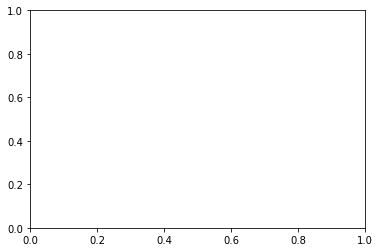

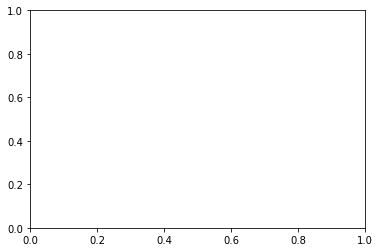

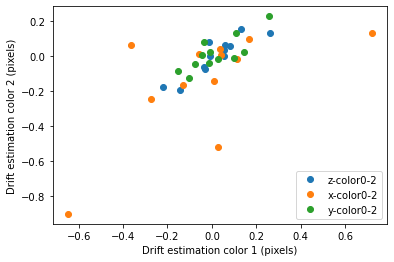

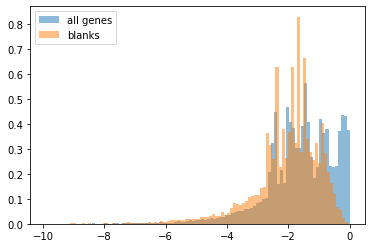

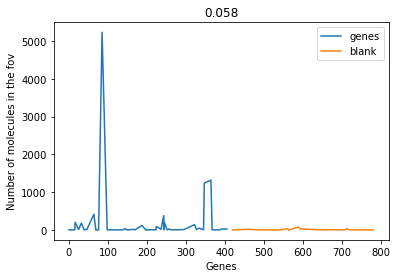

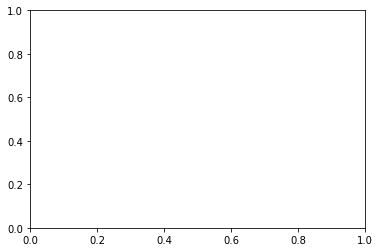

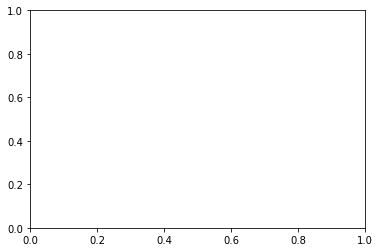

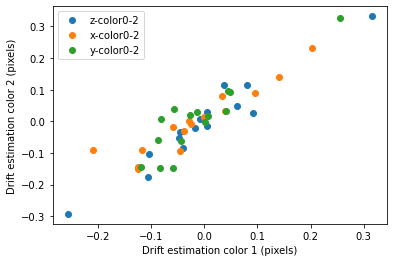

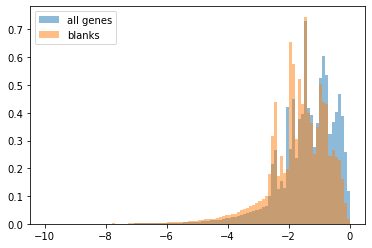

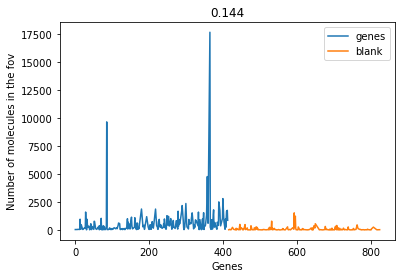

In [16]:
for fov,set_,save_folder in tqdm(paramaters):
    try:
        main_analysisV1(fov,set_,
                       save_folder = save_folder,
                       save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                       save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                       drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                       segm_tag = 'A1_LamA_Nup98')
    except:
        print("Failed at:",fov,set_,save_folder)

### Load library information

In [7]:
tags_lib = ['-e1','-e2','-p12','-p34','-p56','-p711']
fls_lib = ['C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevEP1-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevEP2-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP1P2-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP3P4-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP5P6-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP7P11-code_color2__comb16-4-4.csv']
namesf = []
namesflib = []
for fl_l,tag_l in zip(fls_lib,tags_lib):
    dfL = pd.read_csv(fl_l)
    namesf+=[nm+tag_l if 'blank' in nm else nm for nm in dfL['name']]
    namesflib+=[nm+'--'+tag_l for nm in dfL['name']]
genesf = np.unique(namesf)
dic_nmlib_index = dict(zip(genesf,np.arange(len(genesf))))

dic_libs = {}
for gn in namesflib:
    gn_,lib_ = gn.split('---')[0],gn.split('---')[-1]
    if gn_ not in dic_libs: dic_libs[gn_]=[]
    dic_libs[gn_].append(lib_)


### Load the cell info first - fast

In [ ]:
save_fls_ = glob.glob(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--*')

In [ ]:
#dic_cells = {}
#dic_cells_alt={}
cells_all = None
keys = []
for save_fl in tqdm(save_fls_[:]):
    #save_fl = save_fls_[0]
    dic = np.load(save_fl)
    cells = dic['cellinfo'][1:]
    header_cells = list(dic['header_cells'])
   
    vols = cells[:,header_cells.index('volm')]

    icellsf = cells[:,0].astype(int)
    vols = cells[:,header_cells.index('volm')]
    
    vol_th_ = vols>4000
    icellsf = icellsf[vol_th_]
    cells = cells[vol_th_]
    base = os.path.basename(save_fl).split('--')[-2]+'_'
    keys.extend([base+str(int(cell)) for cell in cells[:,0]])
    cells_all = cells if cells_all is None else np.concatenate([cells_all,cells],axis=0)

    
volms = cells_all[:,1]
index = np.argsort(volms)[::1]
keys_ = np.array(keys)[index]
cells_all_=cells_all[index]
dice_cells = dict(zip(keys_,cells_all_))
keysF = np.array(list(dice_cells.keys()))
Xcells = np.array([dice_cells[cell][[0,-3,-2,-1]]for cell in keysF])

tree = cKDTree(Xcells)
res = tree.query_ball_tree(tree,20)
res_ = []
indCells = Xcells[:,0]

for ir,r in enumerate(tqdm(res)):
    ind_ = indCells[r]
    res_.append(np.array(r)[ind_==indCells[ir]])
dic_match={}
for ir,r in enumerate(res_):
    for r_ in r:
        dic_match[keysF[ir]]=keysF[r_]

### Load cell by gene in df

In [ ]:
#df will be of size genesf and cellidsf
#cell_df,df=None,None
dfF = None
cell_dfF = None
counter=0
dic_cells = {}
cellidsf = []
df = np.zeros([0,len(genesf)])

for save_fl in tqdm(save_fls_[:]):
    #save_fl = save_fls_[0]
    dic = np.load(save_fl)
    XF = dic['XF']
    header = list(dic['header'])
    genes_decoded = dic['genes']
    cells = dic['cellinfo'][1:]
    header_cells = list(dic['header_cells'])
    ### Rethrehold based on score
    iscore = list(header).index('score')
    scoreA = XF[:,iscore]
    keep = scoreA>-0.5



    icell = header.index('cell_id')

    icells = XF[keep,icell].astype(int)
    vols = cells[:,header_cells.index('volm')]

    icellsf = cells[:,0].astype(int)
    vols = cells[:,header_cells.index('volm')]
    
    vol_th_ = vols>4000
    icellsf = icellsf[vol_th_]
    cells = cells[vol_th_]
    
    
    
    
    keep_vol = np.in1d(icells,icellsf) ### is molecule part of a big enough cell
    icells=icells[keep_vol] #final cell indexes of the molecules
    
    base_cell = os.path.basename(save_fl).split('--')[-2]+'_'
    icells_match = np.array([dic_match[base_cell+str(int(icell))]for icell in icells])
    
    ugns,gns_i = np.unique(genes_decoded[keep][keep_vol],return_inverse=True)
    
    
    
    icells_unique,icells_inv = np.unique(icells_match,return_inverse=True)
    #icells_unique = list(icells_unique)+list(np.setdiff1d(icellsf,icells_unique))### add back in the 0 count cells
    #icells_unique = np.array(icells_unique)
    mcell = len(icells_unique)#+1
    gn_cell,gn_cell_cts = np.unique(mcell*gns_i+icells_inv,return_counts=True)
    igns_ = gn_cell//mcell
    icells_ = gn_cell%mcell
    Mcts = np.zeros([mcell,len(ugns)])
    Mcts[icells_,igns_]=gn_cell_cts
    
    _,plate,fov,set_ = os.path.basename(save_fl).split('--')
    plate = plate.lower().split('analysis')[-1]
    ugns_ = [gn+'-'+plate if 'blank' in gn else gn for gn in ugns]
    igns = [dic_nmlib_index[gn] for gn in ugns_]
    
    #icells_unique
    in_common_cells = np.in1d(icells_unique,cellidsf)#,assume_unique=True)
    cellidsf_dic = dict(zip(cellidsf,np.arange(len(cellidsf))))
    in_common_cells_f = np.array([cellidsf_dic[cell_] for cell_ in icells_unique[in_common_cells]],dtype=int)
    #in_common_cells_f = np.in1d(cellidsf,icells_unique)#,assume_unique=True)
    vals = np.zeros([np.sum(in_common_cells),len(genesf)])
    prev_vals = df[in_common_cells_f][:,igns]
    vals[:,igns] = np.max([Mcts[in_common_cells],prev_vals],axis=0)
    if np.sum(in_common_cells_f)>0:
        df[in_common_cells_f] = np.max([vals,df[in_common_cells_f]],axis=0)
    
    #df[in_common_cells_f][:,igns] = np.max([df[in_common_cells_f][:,igns],Mcts[in_common_cells]],axis=0)
    not_in_common_cells = ~in_common_cells
    extra_df = np.zeros([np.sum(not_in_common_cells),len(genesf)])
    extra_df[:,igns]=Mcts[not_in_common_cells]
    df = np.concatenate([df,extra_df])
    cellidsf+=list(icells_unique[not_in_common_cells])
    

### Save dataframes

In [ ]:

len(cellidsf)
dff = pd.DataFrame(df,columns=genesf,index=cellidsf)
cell_df = np.array([dice_cells.get(cell,[0]*len(header_cells)) for cell in cellidsf])
cell_df = pd.DataFrame(cell_df,columns=header_cells,index=cellidsf)
dff.to_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\dff_D16_0p5th.pkl')
cell_df.to_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\cell_df_D16_0p5th.pkl')

### Load and visiualize dataframes

In [9]:
import sys
sys.path.append(r'..//')
from ioMicro import *
import pandas as pd

In [10]:
dff = pd.read_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\dff_D16_0p5th.pkl')
cell_df = pd.read_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\cell_df_D16_0p5th.pkl')

In [27]:
def plot_gene_mosaic_cells(df,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20,viewer=None):
    cell_df_ = cell_df
    xcells,ycells=cell_df_['x_um_abs'],cell_df_['y_um_abs']
    Xcells = np.array([xcells*flipx,ycells*flipy][::transpose]).T
    vols = cell_df_['volm']
    
    cts = np.array(df[gene])#Ptbp1_smFISH
    cts[np.isnan(cts)]=0
    cts = cts/vols*np.median(vols)
    
    ncts = np.clip(cts/nmax,0,1)
    size = sz_min+ncts*(sz_max-sz_min)
    from matplotlib import cm as cmap
    cols = cmap.coolwarm(ncts)
    import napari
    good_cells = slice(None)
    good_cells = np.argsort(cts)
    names_cells = np.array(list(dff.index))[good_cells]
    XC = -Xcells[good_cells,::-1]
    if viewer is None:
        viewer = napari.view_points(XC,size=size[good_cells],face_color=cols[good_cells],name=gene)
    else:
        viewer.add_points(XC,size=size[good_cells],face_color=cols[good_cells],name=gene)
    if plt_fov:
        #ifovs = np.array(list(df.index),dtype=int)//10**5
        ifovs = [int(nm.split('_')[-2]) for nm in names_cells]
        ifov_unk = np.unique(ifovs)
        Xfov = np.array([np.mean(XC[ifovs==ifov],axis=0)for ifov in ifov_unk])
        features =  {'fov':ifov_unk}
        text = {
            'string': '{fov:.0f}',
            'size': 20,
            'color': 'gray',
            'translation': np.array([0, 0]),
        }
        viewer.add_points(Xfov,text=text,features=features,edge_width=0)
    return viewer

In [36]:
svfld =r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\images'
#gene = 'Aif1'
#viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20);
gene = 'P2ry12'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20)
gene = 'Csf1r'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
gene = 'Tmem119'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
gene = 'Cx3cr1'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
if False:
    im = viewer.screenshot(size=(5000,5000))
    viewer.close()
    cv2.imwrite(svfld+os.sep+gene+'_D16.png',im[:,:,[2,1,0,3]])

In [24]:
gns_all = np.sort([gn for gn in dff.columns if 'blank' not in gn])
print(list(gns_all))

['1110008P14Rik', '1500015O10Rik', '1810041L15Rik', '2310069B03Rik', '2610528A11Rik', '2900055J20Rik', '3110035E14Rik', '4833407H14Rik', '4930570B17Rik', '6330403K07Rik', '9630013A20Rik', 'A1cf', 'A230050P20Rik', 'A830009L08Rik', 'A930003A15Rik', 'Abca8a', 'Abcb1b', 'Abcb4', 'Abcg1', 'Abhd15', 'Abhd2', 'Abi3', 'Abi3bp', 'Acer3', 'Ache', 'Acsl3', 'Acta2', 'Actg1', 'Adamts1', 'Adamts5', 'Adamts9', 'Adamtsl4', 'Adarb2', 'Adcy1', 'Adcy2', 'Adcyap1', 'Adgra2', 'Adgrd1', 'Adgre1', 'Adgrl3', 'Adh1', 'Adora2a', 'Adora3', 'Afap1l2', 'Afp', 'Agpat2', 'Agrp', 'Agt', 'Ahcyl2', 'Ahi1', 'Ahnak', 'Aif1', 'Aif1l', 'Akain1', 'Alas2', 'Alb', 'Aldh1a1', 'Aldh1a2', 'Aldh1a7', 'Aldh1l1', 'Aldoa', 'Aldoc', 'Alox12', 'Alox5ap', 'Alx1', 'Alyref', 'Ambra1', 'Amd2', 'Amot', 'Amz1', 'Angpt1', 'Ank2', 'Ankk1', 'Ankrd11', 'Anks6', 'Anln', 'Anp32e', 'Anxa2', 'Anxa5', 'Aoah', 'Ap3s1', 'Apln', 'Apoa1', 'Apoa2', 'Apoc2', 'Apod', 'Apoe', 'Apoo', 'Aqp1', 'Aqp2', 'Aqp3', 'Aqp4', 'Aqp8', 'Arg1', 'Arhgap10', 'Arhgap27', 'A

In [37]:
len(gns_all)

2042

In [42]:
svfld =r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\images'
if not os.path.exists(svfld): os.makedirs(svfld)
    
gene = 'Acsl'
for gene in [gn for gn in gns_all if 'Foxj1' in gn]:
#for gene in ['Malat1', 'H19', 'Col1a1', 'Dpysl3', 'Meg3', 'Ptprs', 'Mapt', 'Dpysl2', 'Gnb1', 'Ywhae', 'Col3a1', 'Sox4', 'Nfix', 'Serpinh1', 'Sparc', 'Agt', 'Nedd4', 'Nnat', 'Ina', 'Xist', 'Uchl1', 'Islr2', 'Igfbpl1', 'Elavl3', 'Sdc3', 'Rab6b', 'Gpm6a', 'Cntf', 'Ndn', 'Csdc2']:
    viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20)
    im = viewer.screenshot(size=(5000,5000))
    viewer.close()
    cv2.imwrite(svfld+os.sep+gene+'_D16.png',im[:,:,[2,1,0,3]])

In [32]:
'Tmem119' in gns_all

True

In [ ]:
TMEM119